<h2><b>Wind Power Generation forecasting</b></h2>

In [143]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
import sklearn 
import math
from scipy.stats import norm
from scipy import stats,signal
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import datetime as dt
from scipy import stats,signal
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima import auto_arima
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

<h3><b>Data Acquisition</b></h3>

As first step we convert the dataset in a dataframe pandas and let’s take a first look at how it looks.

In [2]:
Wind_df = pd.read_csv("C:/Users/alesi/Desktop/Models/Progetto Models/WindEnergy.csv")
Wind_df

utc_timestamp  wind_generation_actual  wind_capacity  \
0     2017-01-01 00:00:00+00:00                291760.0      37149.130   
1     2017-01-02 00:00:00+00:00                295097.0      37152.125   
2     2017-01-03 00:00:00+00:00                666170.0      37155.208   
3     2017-01-04 00:00:00+00:00                686581.0      37160.125   
4     2017-01-05 00:00:00+00:00                261759.0      37163.542   
...                         ...                     ...            ...   
1089  2019-12-26 00:00:00+00:00                132739.0      50424.125   
1090  2019-12-27 00:00:00+00:00                146590.0      50427.000   
1091  2019-12-28 00:00:00+00:00                159126.0      50427.292   
1092  2019-12-29 00:00:00+00:00                349839.0      50434.750   
1093  2019-12-30 00:00:00+00:00                639343.0      50452.000   

      temperature  
0          -2.117  
1          -1.154  
2          -0.239  
3           0.620  
4          -3.908  
...           ...  
1089        2.790  
1090        1.327  
1091       -1.441  
1092       -1.314  
1093        0.542  

[1094 rows x 4 columns]

The dataframe has 4 columns:
- utc_timestamp : year/month/day from 2017/01/01 to 2019/12/30;
- wind_generation_actual : power generated by the turbines in Germany on a specific day;
- wind_capacity : total amount of power generated through a time interval;
- temperature : mean temperature on a specific day.

<h4><b>Check for null and redundant values</b></h4>

In [3]:
Wind_df.info()
# Check null values
Wind_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   utc_timestamp           1094 non-null   object 
 1   wind_generation_actual  1094 non-null   float64
 2   wind_capacity           1094 non-null   float64
 3   temperature             1094 non-null   float64
dtypes: float64(3), object(1)
memory usage: 34.3+ KB


utc_timestamp             0
wind_generation_actual    0
wind_capacity             0
temperature               0
dtype: int64

In [4]:
# Check duplicates
Wind_df[Wind_df.duplicated()]

Empty DataFrame
Columns: [utc_timestamp, wind_generation_actual, wind_capacity, temperature]
Index: []

After these two preliminary analyses we can say that there are no null and redundant values.

In [5]:
Wind_df['utc_timestamp'] = pd.to_datetime(Wind_df['utc_timestamp'])
Wind_df.set_index('utc_timestamp', inplace=True)
Wind_df = Wind_df.asfreq('d')
Wind_df.head()


wind_generation_actual  wind_capacity  temperature
utc_timestamp                                                                
2017-01-01 00:00:00+00:00                291760.0      37149.130       -2.117
2017-01-02 00:00:00+00:00                295097.0      37152.125       -1.154
2017-01-03 00:00:00+00:00                666170.0      37155.208       -0.239
2017-01-04 00:00:00+00:00                686581.0      37160.125        0.620
2017-01-05 00:00:00+00:00                261759.0      37163.542       -3.908

<h3><b>EDA and features overview</b></h3>

In this part we are gonna analyze the different features in order to have a first overview of the dataset's components.

In [6]:
Wind_df.describe().T

count           mean            std        min  \
wind_generation_actual  1094.0  305819.767824  205728.857915  16482.000   
wind_capacity           1094.0   45066.022789    4315.838061  37149.130   
temperature             1094.0      10.050167       7.739158     -9.363   

                                 25%          50%         75%         max  
wind_generation_actual  148552.75000  254332.5000  412570.500  998899.000  
wind_capacity            41447.93750   46073.0000   49203.000   50452.000  
temperature                  3.57725      10.0465      16.566      28.241

Just looking at the table, we can see that there may be the presence of outliers in the wind_generation_actual column because there is a big gap between the 75% e the max value. But it is just a first looking analysis.

<AxesSubplot: >

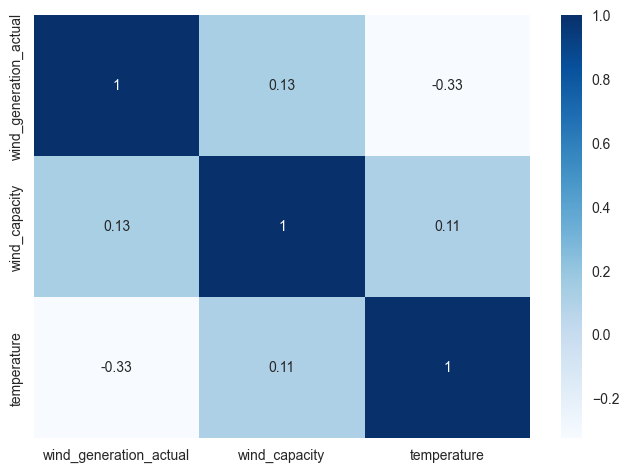

In [7]:
# Correlation matrix
corr = Wind_df.corr()
sns.heatmap(corr,annot=True,cmap='Blues')

The correlation between variables does not seem to be very strong. Note the negative correlation between wind_generation and temperatures due to warmer air, having the same composition as cooler air, contains less energy and needs to move at a higher speed to generate the same amount of power from a wind turbine.

<h5><b>Wind_generation_actual</b></h5>

Text(0.5, 1.0, 'Wind generation through the time')

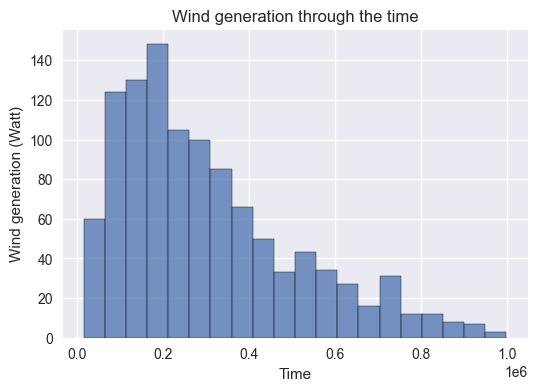

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(Wind_df.wind_generation_actual, bins=20)
plt.ylabel("Wind generation (Watt)")
plt.xlabel('Time')
plt.title("Wind generation through the time")

Text(0.5, 1.0, 'Wind generation through the time')

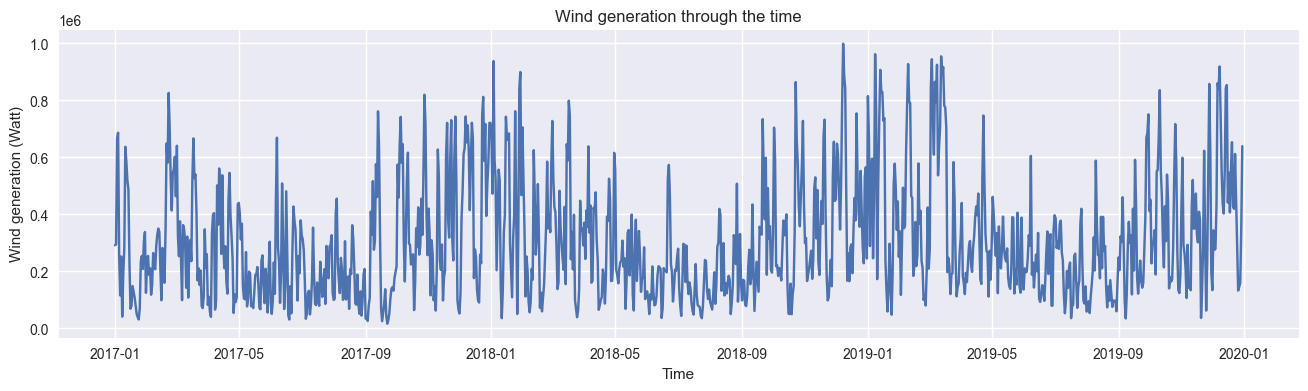

In [9]:
plt.figure(figsize=(16,4))
plt.plot(Wind_df['wind_generation_actual'])
plt.ylabel("Wind generation (Watt)")
plt.xlabel('Time')
plt.title("Wind generation through the time")

We can see that there are recursive patterns and cycles. During the summer time the power is lower than in the winter time so maybe it is a sign of seasonality in the time series.

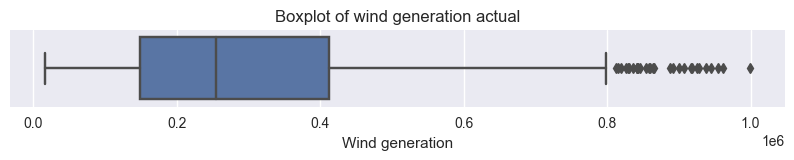

In [10]:
# Box plot to check the presence of outliers
plt.figure(figsize=(10, 1))
sns.boxplot(x=Wind_df['wind_generation_actual'])
plt.title('Boxplot of wind generation actual')
plt.xlabel('Wind generation')
plt.show()

We see that there are some outliers in the wind generation.

In [11]:
# Check the number of outliers in the wind_generation_actual
z_score = np.abs(stats.zscore(Wind_df['wind_generation_actual']))
outliers_num = len(np.where(z_score > 2)[0])
if outliers_num:
    print('wind_generation_actual: {}'.format(outliers_num))

wind_generation_actual: 66


The total number of outliers is 66 which is about 6% of the dataset. 

<h5><b>Wind_capacity</b></h5>

Text(0.5, 1.0, 'Wind capacity through the time')

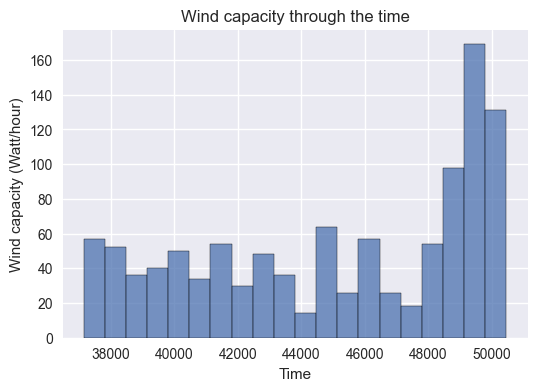

In [12]:
plt.figure(figsize=(6,4))
sns.histplot(Wind_df.wind_capacity, bins=20)
plt.ylabel("Wind capacity (Watt/hour)")
plt.xlabel('Time')
plt.title("Wind capacity through the time")

Text(0.5, 1.0, 'Wind capacity through the time')

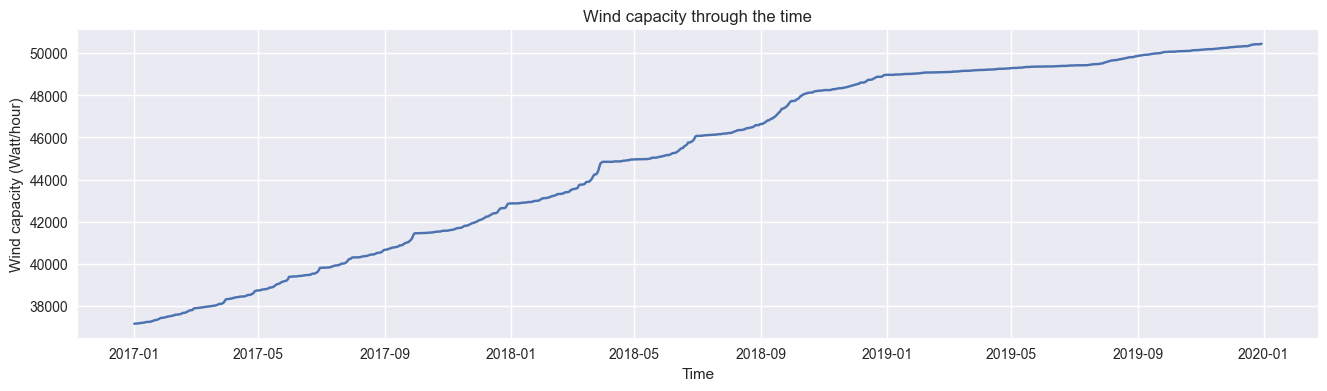

In [13]:
plt.figure(figsize=(16,4))
plt.plot(Wind_df['wind_capacity'])
plt.ylabel("Wind capacity (Watt/hour)")
plt.xlabel('Time')
plt.title("Wind capacity through the time")

Clearly there is a positive trend over the years but you can see some 'bumps' in the period from 09/2017 to 01/2019. These figures reflect Germany's strong commitment to renewable energy. Some explanation of the 'bumps' could be:
- End of Feed-in Tariff (2017): The significant spike in 2017 may be associated with the transition from the feed-in tariff system to an auction-based system in Germany. Developers rushed to complete projects before the transition.
- Initial Auction Cycles (2018-2019): The bumps seen in 2018 and early 2019 could be related to the initial cycles of the auction system, where project approvals and completions tend to cluster around specific auction dates.

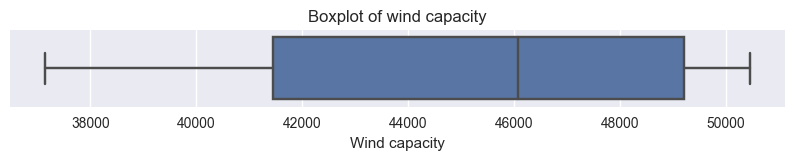

In [14]:
# Box plot to check the presence of outliers
plt.figure(figsize=(10, 1))
sns.boxplot(x=Wind_df['wind_capacity'])
plt.title('Boxplot of wind capacity')
plt.xlabel('Wind capacity')
plt.show()

There is no evidence of outliers.

<h5><b>Temperature</b></h5>

Text(0.5, 1.0, 'temperature through the time')

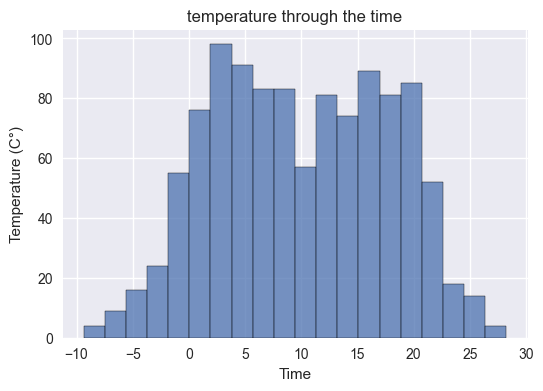

In [15]:
plt.figure(figsize=(6,4))
sns.histplot(Wind_df.temperature, bins=20)
plt.ylabel("Temperature (C°)")
plt.xlabel('Time')
plt.title("temperature through the time")

Text(0.5, 1.0, 'Temperature through the time')

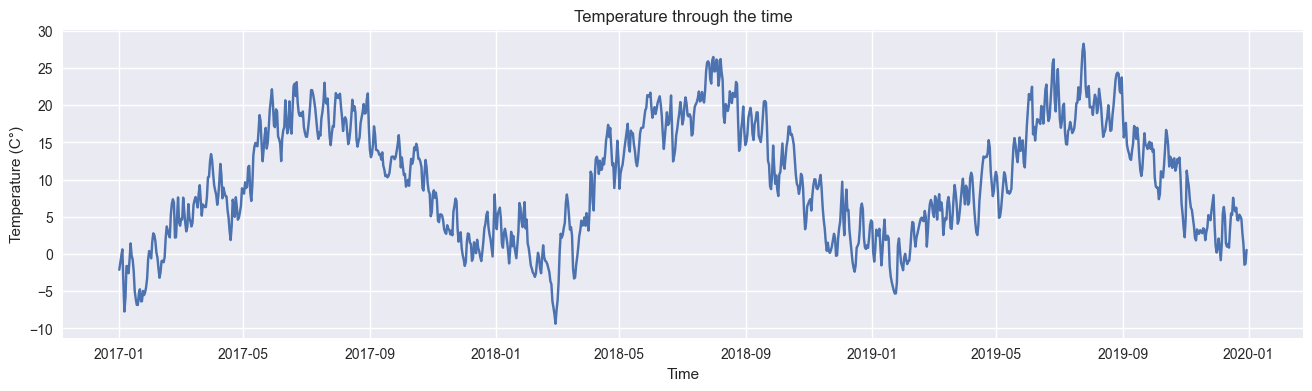

In [16]:
plt.figure(figsize=(16,4))
plt.plot(Wind_df['temperature'])
plt.ylabel("Temperature (C°)")
plt.xlabel('Time')
plt.title("Temperature through the time")

As we could expect you can see without any doubt a seasonality in the summer/winter periods.
An intresting fact could be the low point in the 2018 winter due to the phenomena called 'Beast from the East'. In March 2018, a significant high-pressure system over Scandinavia brought cold air masses from Siberia westwards across Europe, leading to severely cold temperatures.

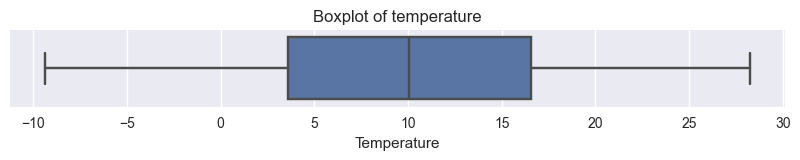

In [17]:
# Box plot to check the presence of outliers
plt.figure(figsize=(10, 1))
sns.boxplot(x=Wind_df['temperature'])
plt.title('Boxplot of temperature')
plt.xlabel('Temperature')
plt.show()

There don’t seem to be outliers.

<h3><b>Stationary test</b></h3>

The main aim of this project is to forecast the wind power generation for the last month of 2019 (December). First of all I will divide the dataset according to the goal.

In [18]:
# Splitting the dataset in the train and test set. 
train_data = Wind_df[:'2019-12-01']
test_data = Wind_df['2019-12-01':]
wind_generation_train = Wind_df['wind_generation_actual'][:'2019-12-01'] 
wind_generation_test = Wind_df['wind_generation_actual']['2019-12-01':]

<h5><b>ADFuller test</b></h5>

To determine if our data is stationary or not we have to use the ADFuller and the KPSS tests.

The **Augmented Dickey-Fuller** (ADF) test is a type of statistical test called a unit root test.
- Null Hypothesis (H0):  time series has a unit root, and it is non-stationary.
- Alternative Hypothesis (H1): time series does not have a unit root, meaning it is stationary.
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [19]:
# ADF test
def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')

adfuller_test(wind_generation_train)    

ADF Statistic: -10.770881147570158
p-value:  2.3860555693459234e-19
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
We can reject the null hypothesis (H0) --> data is stationary


The p-value is less than 0.05 so we can reject the null hypothesis (H0) at the 5% significance level. This means that our time series is stationary.

<h5><b>KPSS test</b></h5>

The **KPSS** tests for the null hypothesis that the series is stationary around a deterministic trend. 
- Null Hypothesis (H0): time series is trend stationary.
- Alternative Hypothesis (H1): time series is not trend stationary.
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data is trend stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data is not trend stationary.

In [20]:
# KPSS test
def kpss_test(data):
  kpss_out = kpss(data,regression='ct', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')

kpss_test(wind_generation_train)    

print('-------------------------------------------')

# KPSS test
def kpss_test(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')

kpss_test(wind_generation_train)   

KPSS Statistic: 0.16055636659786887
p-value:  0.037869694501775936
We can reject the null hypothesis (H0) --> data is not trend stationary
-------------------------------------------
KPSS Statistic: 0.29625428640285684
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


Given the test results and the visual inspection of the time series plot, the data seems to exhibit a trend component. Therefore, it is more appropriate to model the series as trend stationary (regression='ct') rather than purely level stationary (regression='c').

The p-value is less than 0.05 for the trend stationary so we can reject the null hypothesis (H0) at the 5% significance level. This means that our time series is not trand stationary so we have to do differencing to get stationary but first we'll check the seasonality part.

<h3><b>Frequency analysis</b></h3>

We'll use the periodogram to estimate the power spectral density (PSD) of a signal. It helps in identifying the dominant frequencies present in the time series data.

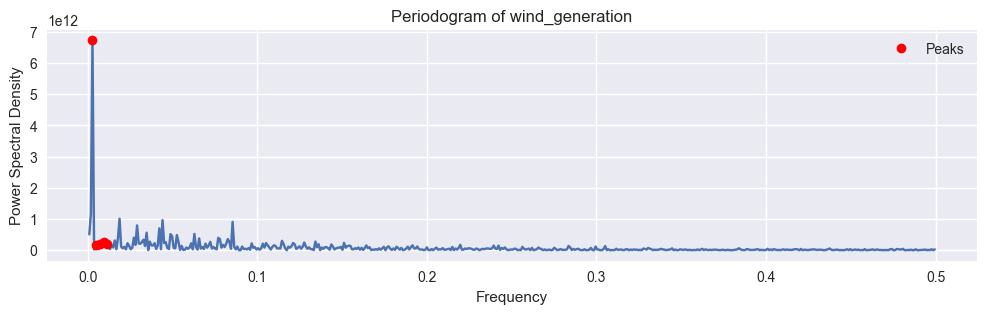

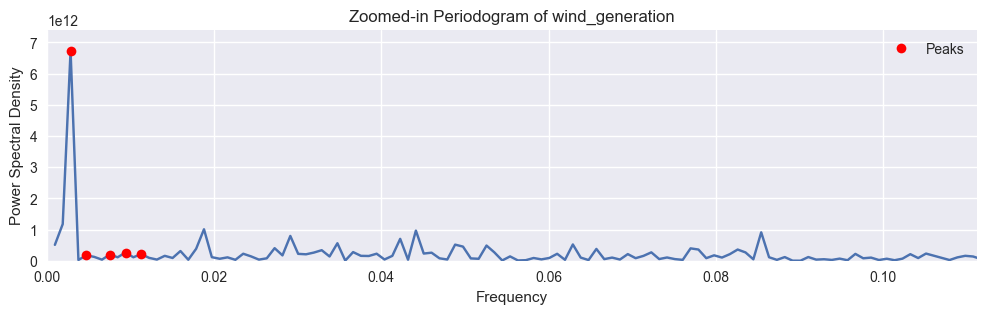

Freq   Period         Power
0  0.002817  355.000  6.732934e+12
1  0.004695  213.000  1.724521e+11
2  0.007512  133.125  1.977423e+11
3  0.009390  106.500  2.634101e+11
4  0.011268   88.750  2.121807e+11

In [21]:
# Seasonality using the periodogram
Fs = 1 # our unit of measures is "days", thus 1 per day
f_per, Pxx_per = signal.periodogram(wind_generation_train,Fs,detrend=False,window='boxcar',return_onesided=True,scaling='density')
f_per = f_per[1:] # Remove the Zero Frequency Component
Pxx_per = Pxx_per[1:]

# Find peaks
peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=100000)[0]
peak_freq = f_per[peaks]
peak_power = Pxx_per[peaks]

# Select only the first five peaks
peak_freq_top5 = peak_freq[:5]
peak_power_top5 = peak_power[:5]

# Plot the periodogram
plt.figure(figsize=(12, 3))
plt.plot(f_per, Pxx_per)
plt.plot(peak_freq_top5, peak_power_top5, 'ro', label='Peaks')
plt.title('Periodogram of wind_generation')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()

# Plot a zoomed-in view of the peaks
plt.figure(figsize=(12, 3))
plt.plot(f_per, Pxx_per)
plt.plot(peak_freq_top5, peak_power_top5, 'ro', label='Peaks')
plt.xlim(0, peak_freq_top5.max() + 0.1)  # Zoom in on the frequency range around the peaks
plt.ylim(0, peak_power_top5.max() + peak_power_top5.max() * 0.1)  # Zoom in on the power range around the peaks
plt.title('Zoomed-in Periodogram of wind_generation')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()

# Create and display a table of the first five peaks
table = {'Freq': peak_freq_top5, 'Period': 1/peak_freq_top5, 'Power': peak_power_top5}
peaks_tab = pd.DataFrame(table)
display(peaks_tab)


We see that the most highest frquencies represents the periods 355, 213, 133, 106 and 89 days. So we have five possibilities for the seasonalities. I'll use the seasonality of 355 approximated to 365 (a year) and then the 88 approximated to 90 (three months) reflects the seasons. I don't use the others periods 213 (seven months), 133 (four and a half months) and 106 (three and a half months) because do not seem relevant in my opinion. 

<h3><b>Seasonal difference for trend stationary</b></h3>

Let's go back to the stationary. Now that we have found the most frequent periods in frequency analysis we have to do a difference on the train dataset and then test the stationary.

Text(0.5, 1.0, 'Wind generation difference 365')

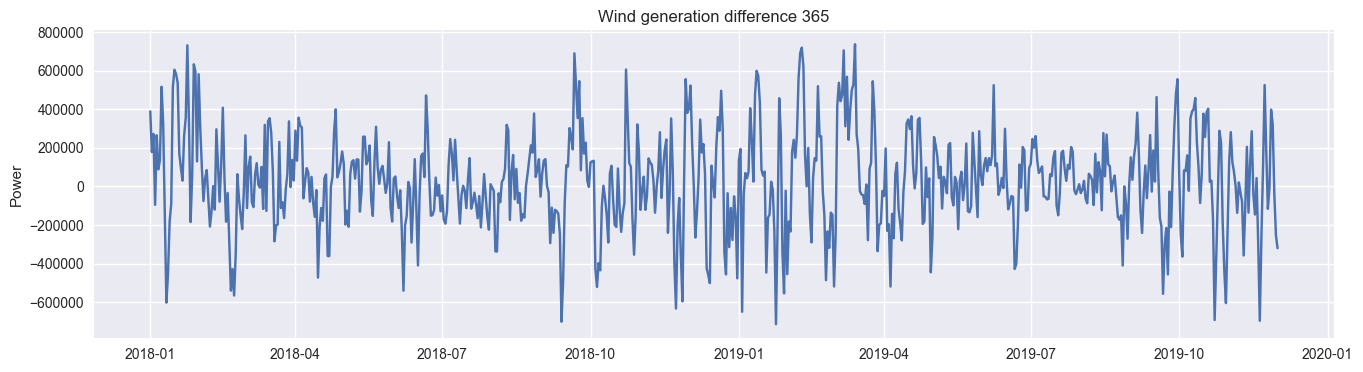

In [22]:
# 365 difference
wind_generation_diff365_train = wind_generation_train.diff(365).dropna()
train_data_diff365 = train_data.diff(365).dropna()
fig = plt.figure(figsize=(16,4))
plt.plot(wind_generation_diff365_train)
plt.ylabel('Power')
plt.title('Wind generation difference 365')

In [23]:
# Stationary test on 365 difference
adfuller_test(wind_generation_diff365_train)
print('--------------------------------')
kpss_test(wind_generation_diff365_train)

ADF Statistic: -13.767585382019107
p-value:  9.818651975747313e-26
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
We can reject the null hypothesis (H0) --> data is stationary
--------------------------------
KPSS Statistic: 0.0605761165764053
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


Our time serie is stationary and trend stationary.

Text(0.5, 1.0, 'Wind generation difference 365')

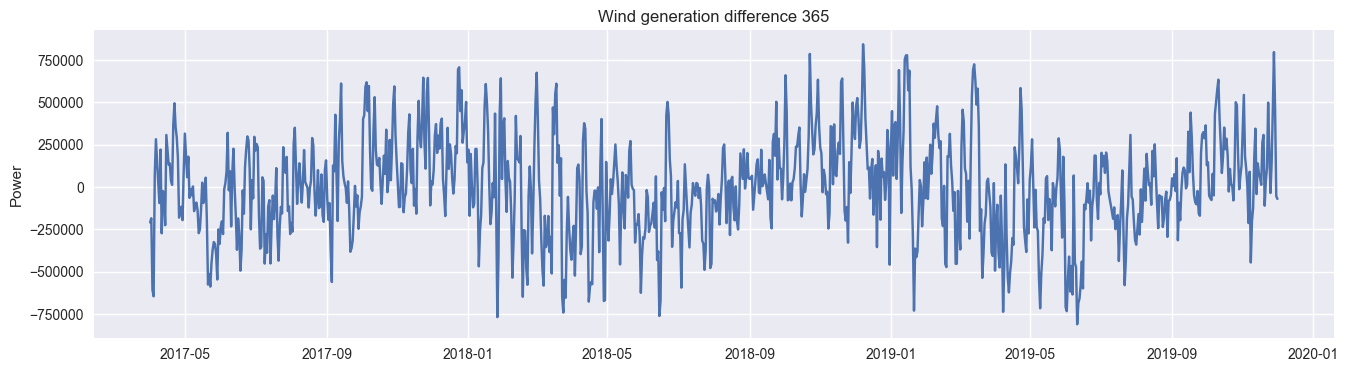

In [24]:
# 90 difference
wind_generation_diff90_train = wind_generation_train.diff(90).dropna()
train_data_diff90 = train_data.diff(90).dropna()
fig = plt.figure(figsize=(16,4))
plt.plot(wind_generation_diff90_train)
plt.ylabel('Power')
plt.title('Wind generation difference 365')

In [25]:
# Stationary test on 90 difference
adfuller_test(wind_generation_diff90_train)
print('---------------------------------')
kpss_test(wind_generation_diff90_train)

ADF Statistic: -11.433530381495444
p-value:  6.429922228041894e-21
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568
We can reject the null hypothesis (H0) --> data is stationary
---------------------------------
KPSS Statistic: 0.15181791947598347
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


Our time serie is stationary and trend stationary but with higher value of KPSS Statistic

<h3><b>ACF and PACF</b></h3>

Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are tools used in time series analysis to identify the presence and strength of relationships between observations in a time series. These functions are particularly useful for determining the order of ARIMA models (AutoRegressive Integrated Moving Average).

If we see a lot of lags with values which are outside the confidence interval then it means that at this specific lag there is some correlation between the data and it is not a good sign.

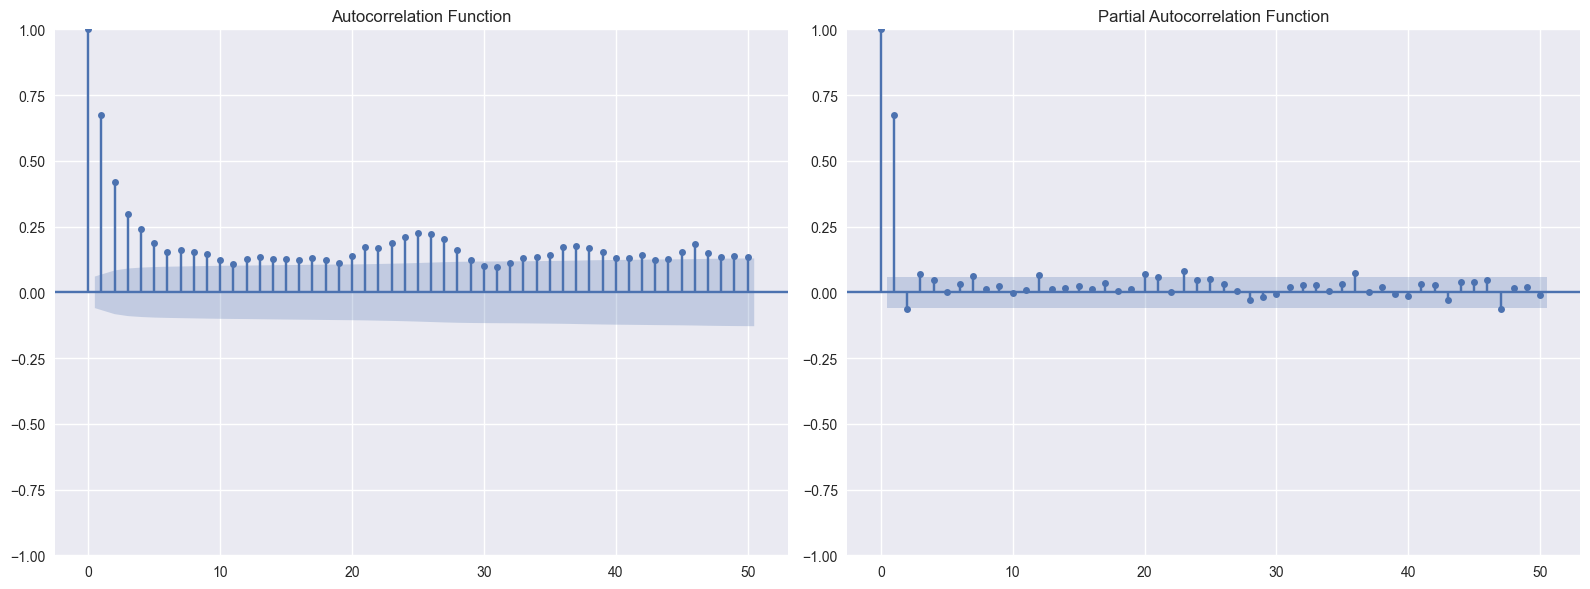

In [26]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot ACF
plot_acf(wind_generation_train, lags=50, ax=ax[0])
ax[0].set_title('Autocorrelation Function')

# Plot PACF
plot_pacf(wind_generation_train, lags=50, ax=ax[1], method='ywm')
ax[1].set_title('Partial Autocorrelation Function')

# Show the plots
plt.tight_layout()
plt.show()

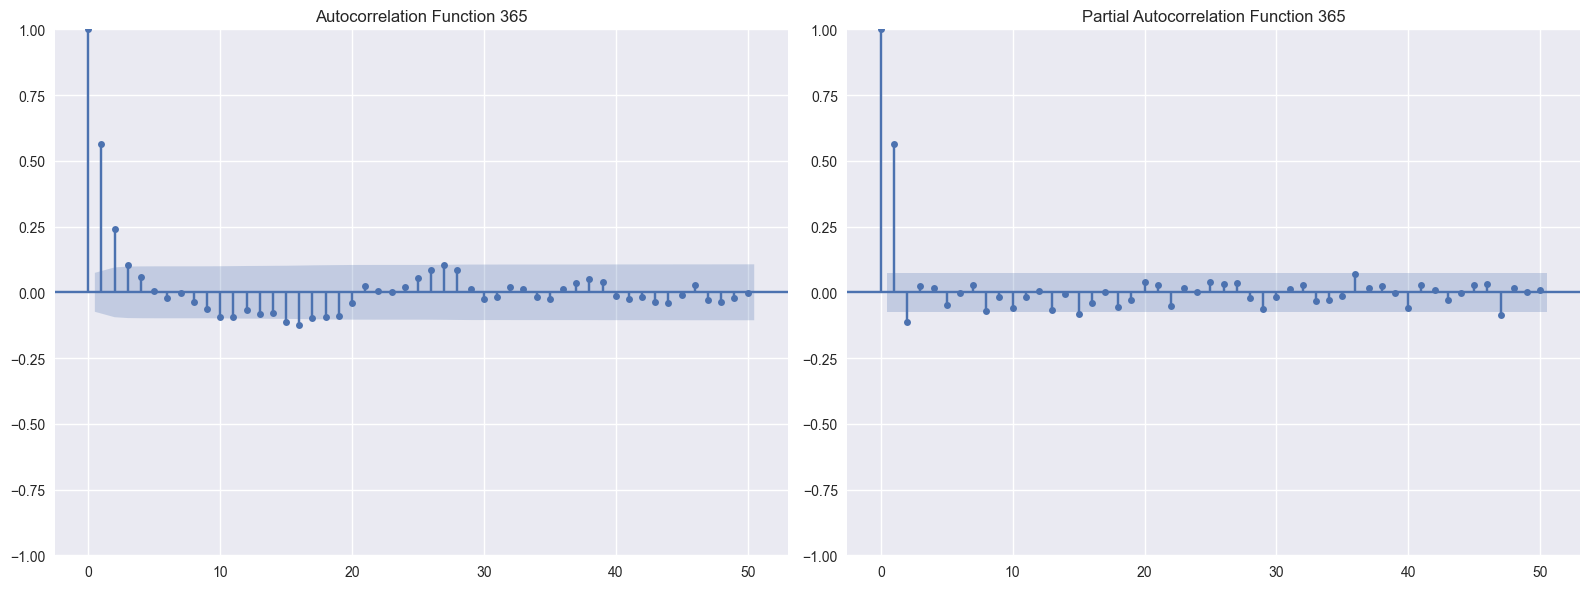

In [27]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot ACF
plot_acf(wind_generation_diff365_train, lags=50, ax=ax[0])
ax[0].set_title('Autocorrelation Function 365')

# Plot PACF
plot_pacf(wind_generation_diff365_train, lags=50, ax=ax[1], method='ywm')
ax[1].set_title('Partial Autocorrelation Function 365')

# Show the plots
plt.tight_layout()
plt.show()

If we compare the two graphs before and after difference, we immediately notice that there are many fewer values outside the confidence interval, especially in the ACF.

<h3><b>ETS</b></h3>

The ETS (Error, Trend, Seasonality) model is a powerful approach for time series forecasting that decomposes the time series into three components: Error, Trend, and Seasonality. ETS models are particularly effective for data with strong seasonal patterns. The ETS framework includes several models, depending on whether these components are additive or multiplicative. An important characteristic is that ETS can handle big values for the seasonality unlike the SARIMA that fail.

In [ ]:
best_map = 100
best_i = 0
for i in range(2,100):
    model_1 = ETSModel(Wind_df['wind_generation_actual'], trend='add', seasonal='add',seasonal_periods=i).fit()
    pred_1 = model_1.get_prediction(start=wind_generation_test.index[0], end=wind_generation_test.index[-1])
    df_1 = pred_1.summary_frame()
    map = mean_absolute_percentage_error(wind_generation_test, df_1['mean'])
    if(map < best_map):
        best_map = map
        best_i = i


# Print the results after the loop
print(f"Best seasonal period: {best_i}")
print(f"Best MAPE: {best_map}")


After running the code (22 minutes) with 200 iteration, the best seasonal period is 140 with a MAPE (Mean absolute percentage error) of 0.319.

If I change the iteration with 100, the computational time is 3 minutes and the best seasonal period is 68 with a MAPE of 0.337.


<h4><b>ETS 140</b></h4>

<h5><b>Model</b></h5>

In [28]:
model_ETS_140 = ETSModel(Wind_df['wind_generation_actual'], trend='add', seasonal='add',seasonal_periods=140).fit(disp=False)
pred_ETS_140 = model_ETS_140.get_prediction(start=wind_generation_test.index[0], end=wind_generation_test.index[-1])
df_ETS_140 = pred_ETS_140.summary_frame()

<h5><b>Durbin-Watson</b></h5>

- Durbin-Watson varies between 0 and 4.
- Durbin-Watson  about equal to 2 indicates that there is no autocorrelation in the residues.
- Durbin-Watson  less than 2 suggests positive autocorrelation.
- Durbin-Watson  above 2 suggests negative autocorrelation.

In [29]:
res_ETS140 = wind_generation_test - df_ETS_140['mean']
durbin_watson(res_ETS140)

1.575463811583575

<h5><b>Forecast</b></h5>

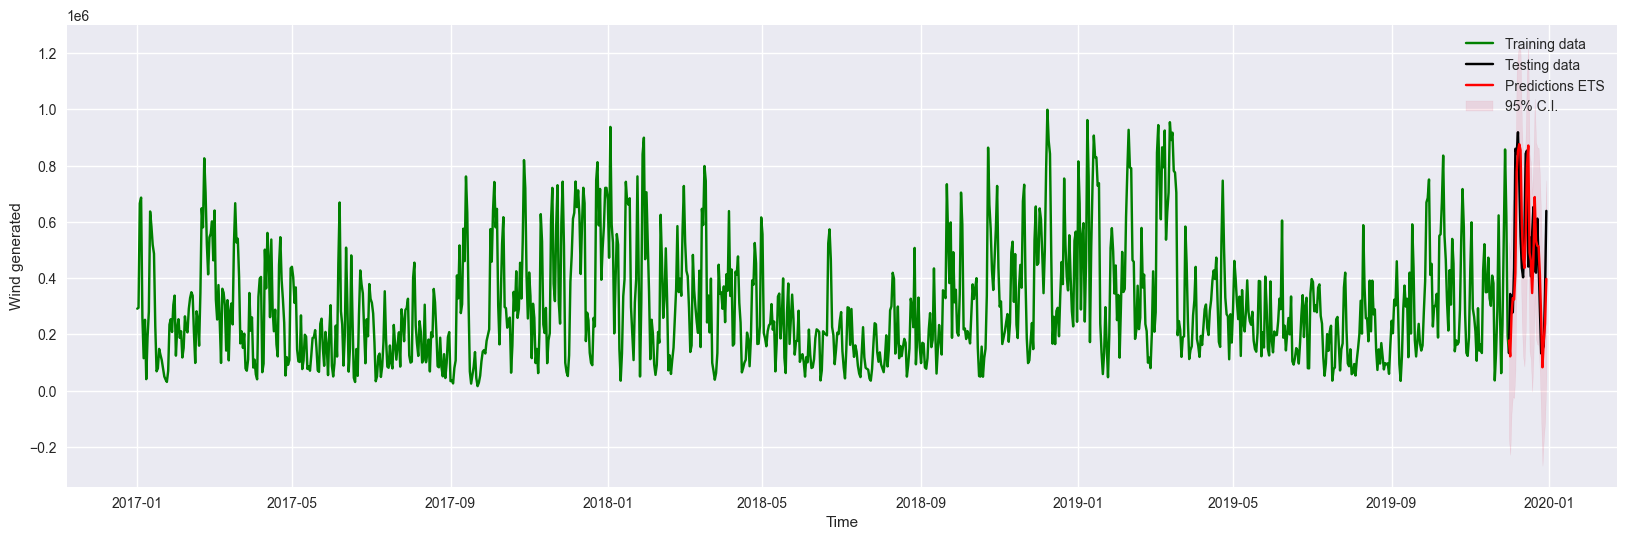

In [30]:
fig = plt.figure(figsize=(20,6))
plt.plot(wind_generation_train, color='green',label='Training data')
plt.plot(wind_generation_test, color='black', label='Testing data')
plt.plot(df_ETS_140['mean'], color='red', label='Predictions ETS')
plt.fill_between(df_ETS_140.index, df_ETS_140['pi_lower'], df_ETS_140['pi_upper'], alpha=.1, color='crimson', label='95% C.I.') # Confidence interval
plt.xlabel('Time')
plt.ylabel('Wind generated')
plt.legend()

<h5><b>Zoom</b></h5>

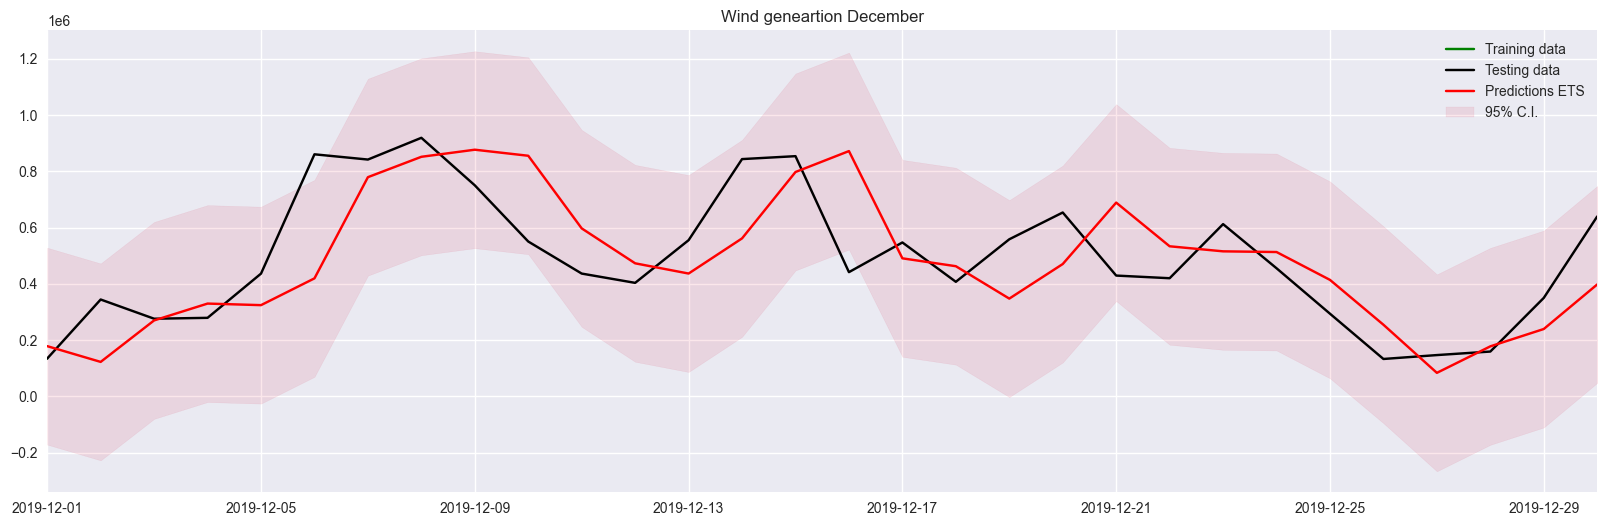

In [31]:
# Plot the data and predictions
fig = plt.figure(figsize=(20,6))
plt.plot(wind_generation_train, color='green', label='Training data')
plt.plot(wind_generation_test, color='black', label='Testing data')
plt.plot(df_ETS_140['mean'], color='red', label='Predictions ETS')
plt.fill_between(df_ETS_140.index, df_ETS_140['pi_lower'], df_ETS_140['pi_upper'], alpha=.1, color='crimson', label='95% C.I.')

# Zoom into the prediction part
start_index = df_ETS_140.index[-30]  # Start of zoom
end_index = df_ETS_140.index[-1]      # End of zoom
plt.xlim(start_index, end_index)
plt.title('Wind geneartion December')
plt.legend()
plt.show()

<h5><b>Plots</b></h5>

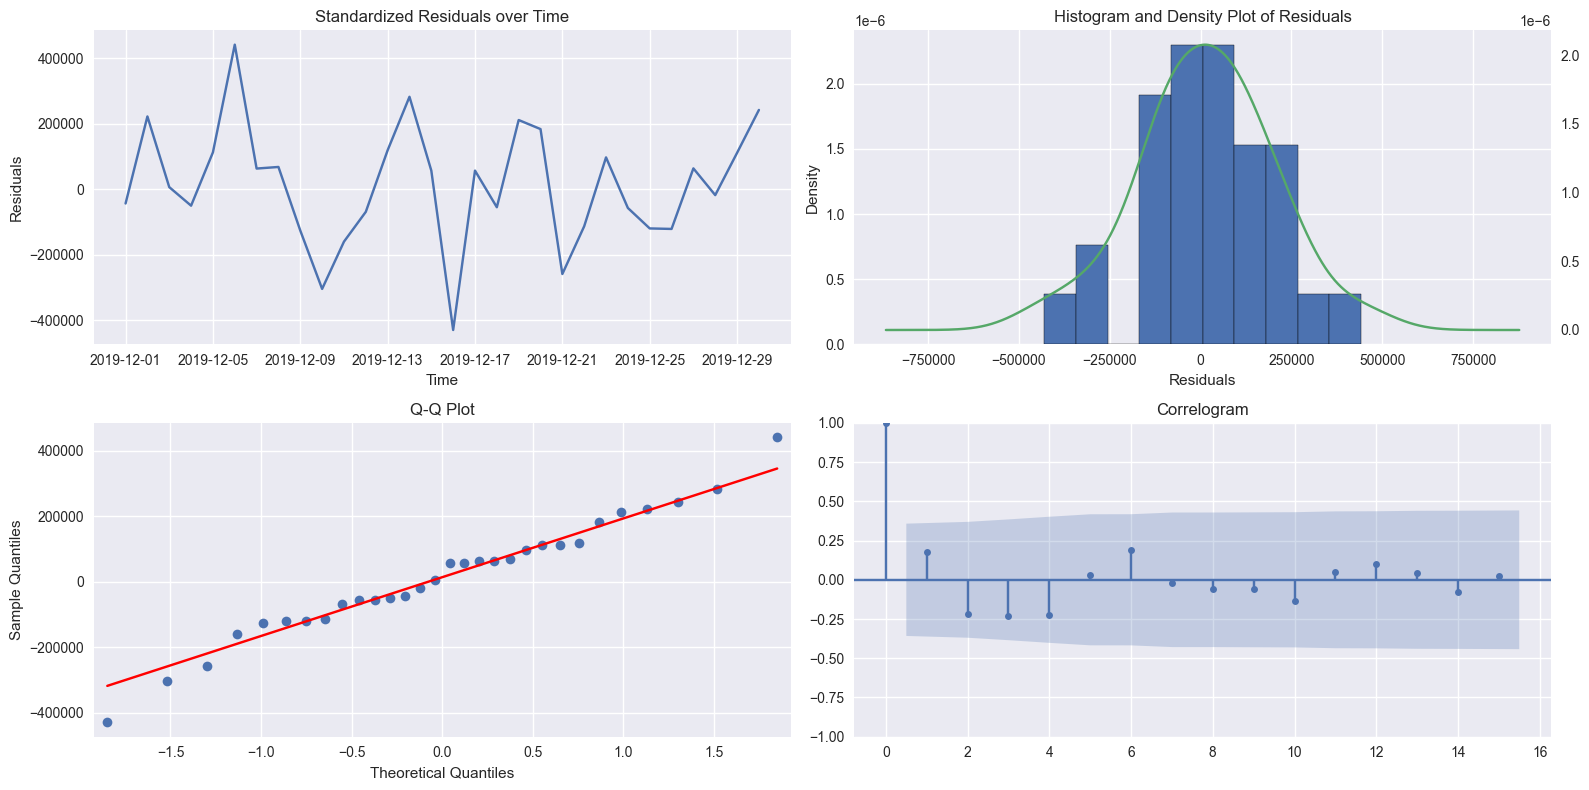

In [32]:
# PLots
residuals = wind_generation_test - df_ETS_140['mean']

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# 1. Standardized residuals over time
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Standardized Residuals over Time')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residuals')

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=10, edgecolor='black', density=True)
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')

# Adding KDE plot for histogram
residuals.plot(kind='kde', ax=axes[0, 1], secondary_y=True, title='Histogram and Density Plot of Residuals')

# 3. Q-Q plot of residuals
sm.qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, ax=axes[1, 1])
axes[1, 1].set_title('Correlogram')

plt.tight_layout()
plt.show()

<h5><b>Metrics</b></h5>

In [188]:
ets_140 = {
    'Model_name': 'ETS Daily 140', 
    'AIC': model_ETS_140.aic, 
    'BIC': model_ETS_140.bic,
    'MAE': mean_absolute_error(wind_generation_test, df_ETS_140['mean']), 
    'MAPE': mean_absolute_percentage_error(wind_generation_test, df_ETS_140['mean']),
    'RMSE': mean_squared_error(wind_generation_test, df_ETS_140['mean'], squared=False)
}
ets_140

{'Model_name': 'ETS Daily 140',
 'AIC': 29854.85745276972,
 'BIC': 30584.506466285082,
 'MAE': 142118.5584496055,
 'MAPE': 0.3190121569651643,
 'RMSE': 180006.90990357875}

<h4><b>ETS 68</b></h4>

<h5><b>Model</b></h5>

In [34]:
model_ETS_68 = ETSModel(Wind_df['wind_generation_actual'], trend='add', seasonal='add',seasonal_periods=68).fit(disp=False)
pred_ETS_68 = model_ETS_68.get_prediction(start=wind_generation_test.index[0], end=wind_generation_test.index[-1])
df_ETS_68 = pred_ETS_68.summary_frame()

<h5><b>Durbin-Watson</b></h5>

In [35]:
res_ETS68 = wind_generation_test - df_ETS_68['mean']
durbin_watson(res_ETS68)

1.3095192590857951

<h5><b>Forecast</b></h5>

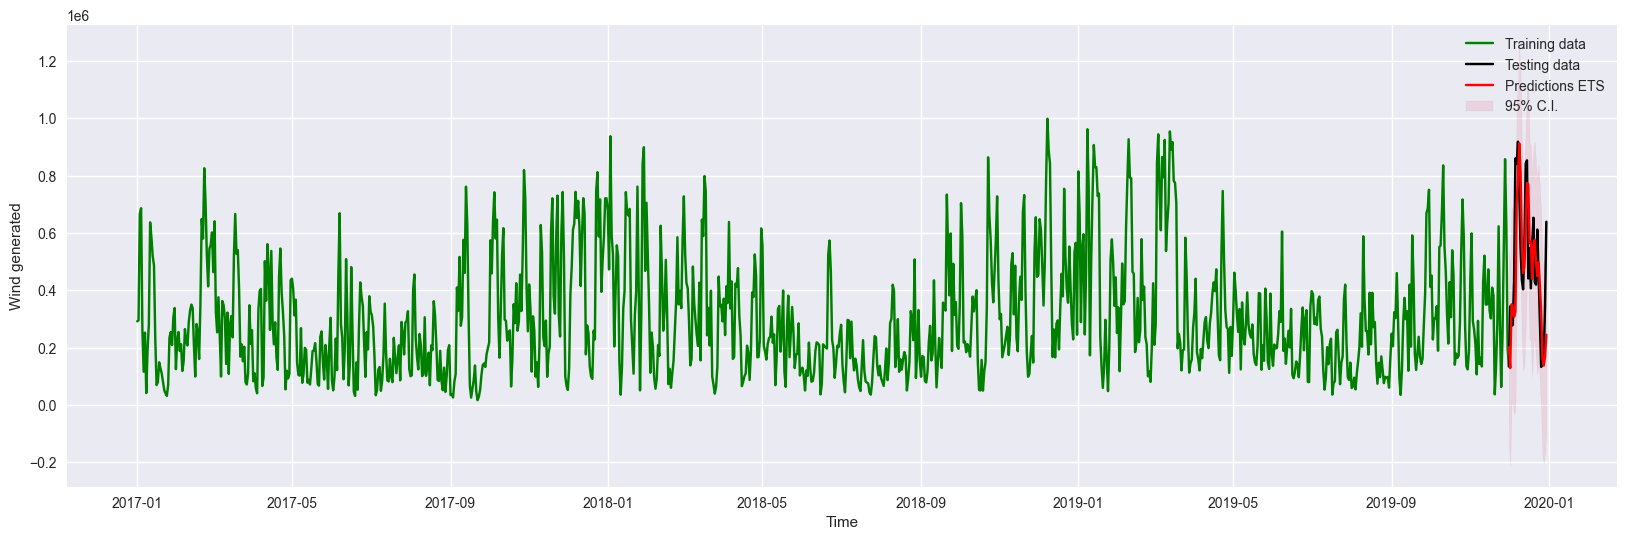

In [36]:
fig = plt.figure(figsize=(20,6))
plt.plot(wind_generation_train, color='green',label='Training data')
plt.plot(wind_generation_test, color='black', label='Testing data')
plt.plot(df_ETS_68['mean'], color='red', label='Predictions ETS')
plt.fill_between(df_ETS_68.index, df_ETS_68['pi_lower'], df_ETS_68['pi_upper'], alpha=.1, color='crimson', label='95% C.I.') # Confidence interval
plt.xlabel('Time')
plt.ylabel('Wind generated')
plt.legend()

<h5><b>Zoom</b></h5>

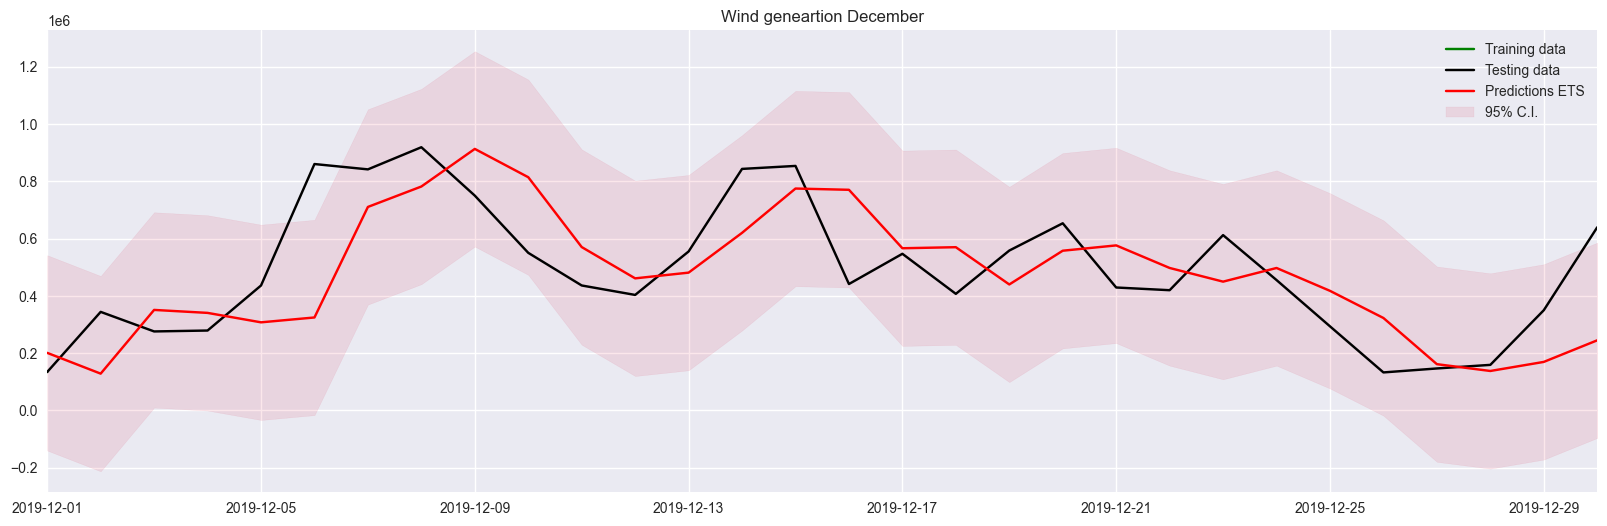

In [37]:
# Plot the data and predictions
fig = plt.figure(figsize=(20,6))
plt.plot(wind_generation_train, color='green', label='Training data')
plt.plot(wind_generation_test, color='black', label='Testing data')
plt.plot(df_ETS_68['mean'], color='red', label='Predictions ETS')
plt.fill_between(df_ETS_68.index, df_ETS_68['pi_lower'], df_ETS_68['pi_upper'], alpha=.1, color='crimson', label='95% C.I.')

# Zoom into the prediction part
start_index = df_ETS_68.index[-30]  # Start of zoom
end_index = df_ETS_68.index[-1]      # End of zoom
plt.xlim(start_index, end_index)
plt.title('Wind geneartion December')
plt.legend()
plt.show()

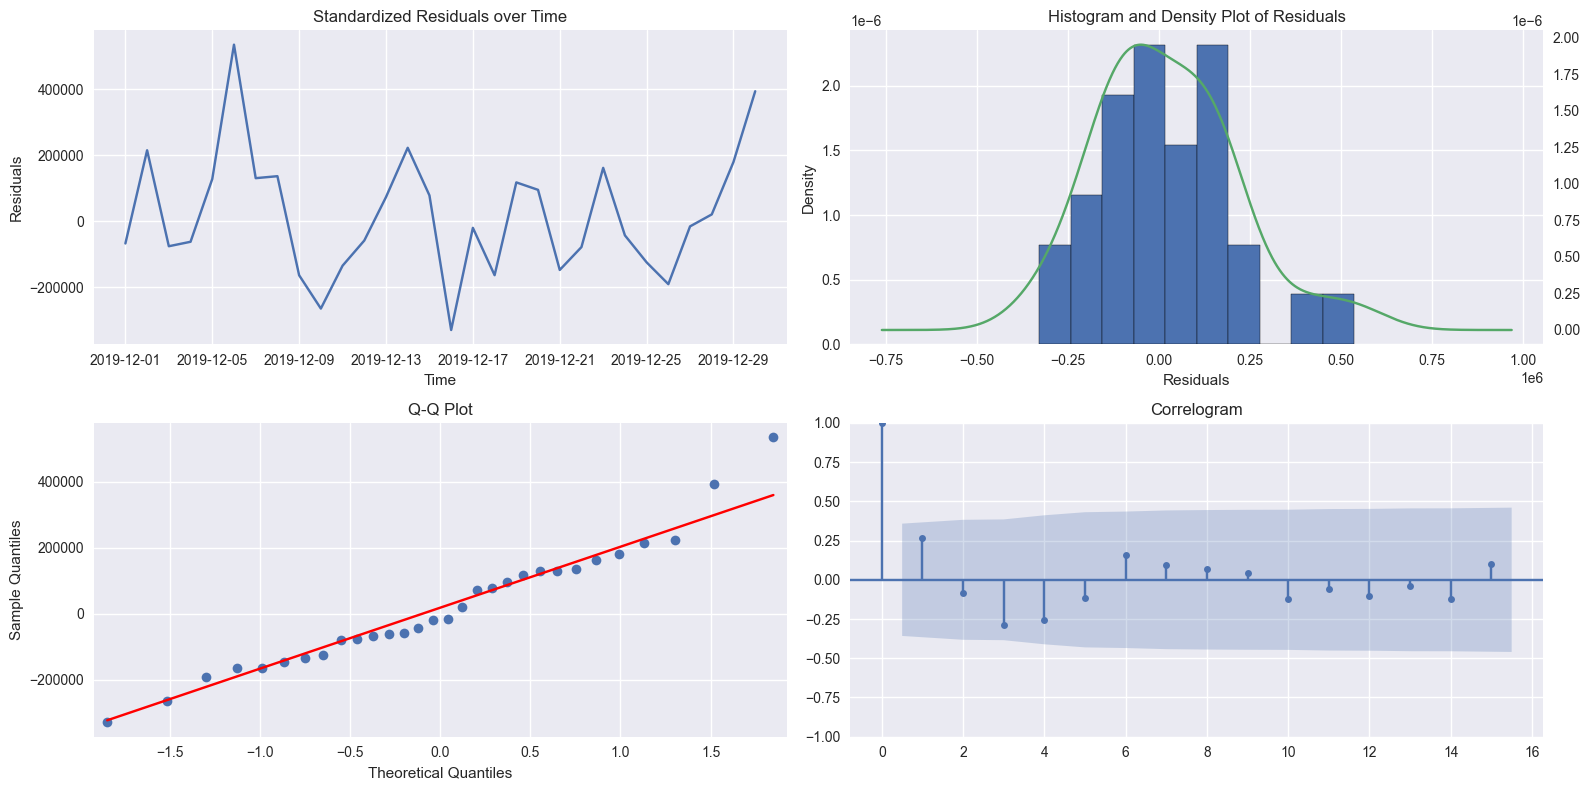

In [38]:
# PLots
residuals = wind_generation_test - df_ETS_68['mean']

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# 1. Standardized residuals over time
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Standardized Residuals over Time')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residuals')

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=10, edgecolor='black', density=True)
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')

# Adding KDE plot for histogram
residuals.plot(kind='kde', ax=axes[0, 1], secondary_y=True, title='Histogram and Density Plot of Residuals')

# 3. Q-Q plot of residuals
sm.qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, ax=axes[1, 1])
axes[1, 1].set_title('Correlogram')

plt.tight_layout()
plt.show()

<h5><b>Metrics</b></h5>

In [189]:
ets_68 = {
    'Model_name': 'ETS Daily 68', 
    'AIC': model_ETS_68.aic,
    'BIC': model_ETS_68.bic,
    'MAE': mean_absolute_error(wind_generation_test, df_ETS_68['mean']), 
    'MAPE': mean_absolute_percentage_error(wind_generation_test, df_ETS_68['mean']),
    'RMSE': mean_squared_error(wind_generation_test, df_ETS_68['mean'], squared=False)
}
ets_68

{'Model_name': 'ETS Daily 68',
 'AIC': 29653.552905561857,
 'BIC': 30023.37500830252,
 'MAE': 147544.28641911398,
 'MAPE': 0.33749327293019143,
 'RMSE': 185596.87930432777}

<h3><b>SARIMA MODELS</b></h3>

If I want to use the models of the SARIMA family it is necessary, however, an adaptation of the data because using daily time series and with large seasonality leads to high computational times to find the parameters or to run the processes themselves. So one possible solution is to group the data on a weekly or monthly basis.

<h4><b>Weekly data</b></h4>

In [40]:
Wind_weekly = Wind_df.resample('1W').mean()

Now the test set results in only 4 values versus the 30 in the daily case. So for mine purpose I'll use 15 weeks just to have a fair test set.

In [41]:
train_data_w = Wind_weekly['wind_generation_actual'][:-15]
test_data_w = Wind_weekly['wind_generation_actual'][-15:]

Text(0.5, 1.0, 'Wind generation through the weeks')

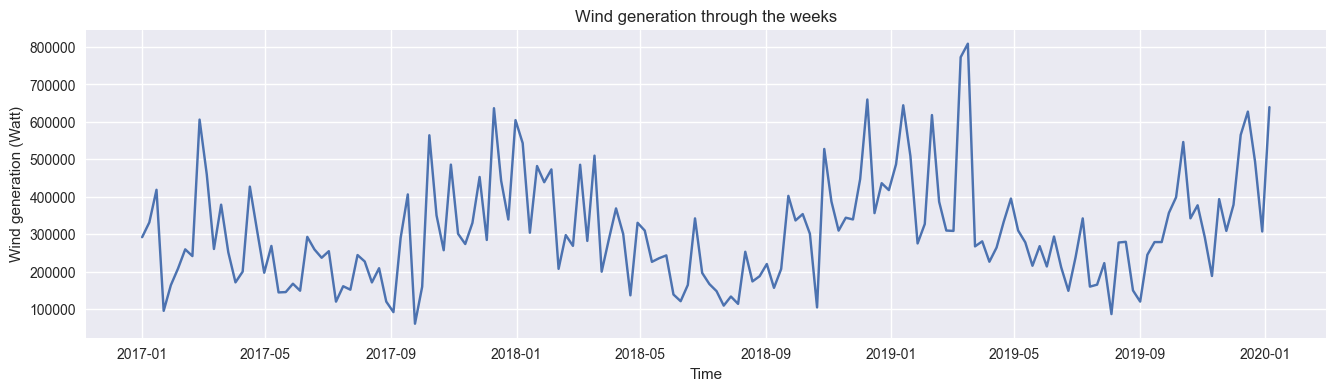

In [42]:
plt.figure(figsize=(16,4))
plt.plot(Wind_weekly['wind_generation_actual'])
plt.ylabel("Wind generation (Watt)")
plt.xlabel('Time')
plt.title("Wind generation through the weeks")

Text(0.5, 1.0, 'Wind generation through the weeks')

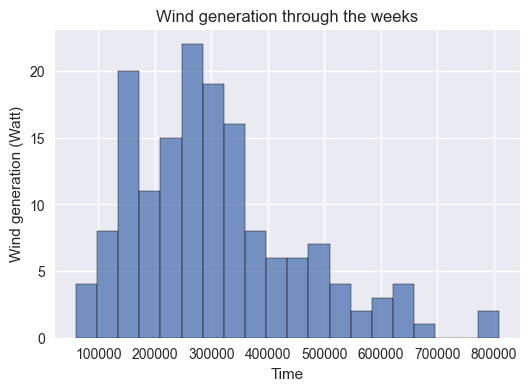

In [43]:
plt.figure(figsize=(6,4))
sns.histplot(Wind_weekly.wind_generation_actual, bins=20)
plt.ylabel("Wind generation (Watt)")
plt.xlabel('Time')
plt.title("Wind generation through the weeks")

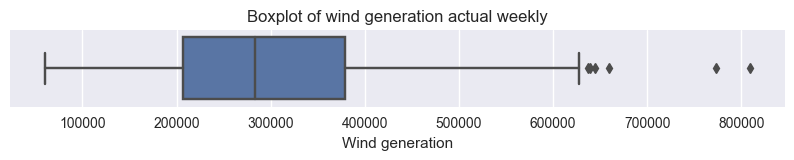

In [44]:
# Box plot to check the presence of outliers
plt.figure(figsize=(10, 1))
sns.boxplot(x=Wind_weekly['wind_generation_actual'])
plt.title('Boxplot of wind generation actual weekly')
plt.xlabel('Wind generation')
plt.show()

In [45]:
# Check the number of outliers in the wind_generation_actual
z_score = np.abs(stats.zscore(Wind_weekly['wind_generation_actual']))
outliers_num = len(np.where(z_score > 2)[0])
if outliers_num:
    print('wind_generation_actual: {}'.format(outliers_num))

wind_generation_actual: 10


The total number of outliers is 10 which is about 6.4% of the dataset. 

<h4><b>Stationary test</b></h4>

In [46]:
# Test for stationarity
adfuller_test(train_data_w)
print('----------------------')
kpss_test(train_data_w)

ADF Statistic: -2.144110060839226
p-value:  0.22715141140183176
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
We cannot reject the null hypothesis (H0) --> data is non-stationary
----------------------
KPSS Statistic: 0.12318604025139107
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


The problem is opposite to that of the daily case. We have a trend stationary but a non-stationary. We'll do the frequency analysis to find out the new periods.

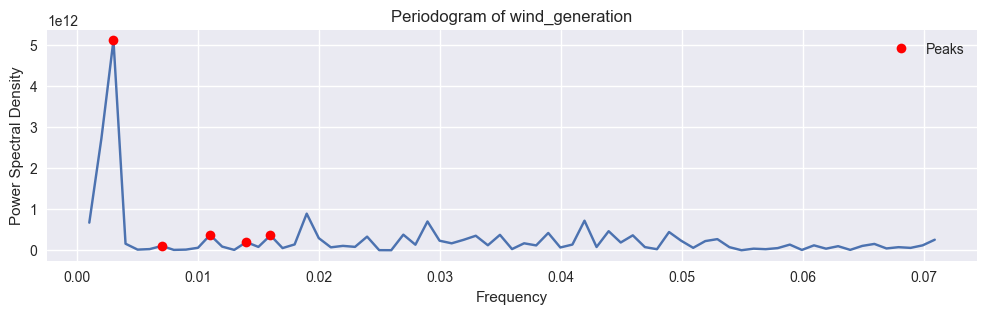

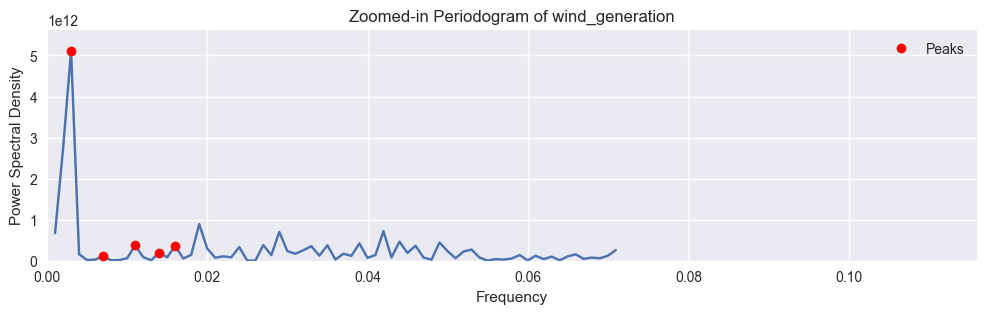

Freq      Period         Power
0  0.002997  333.666667  5.115408e+12
1  0.006993  143.000000  1.053658e+11
2  0.010989   91.000000  3.742941e+11
3  0.013986   71.500000  1.991129e+11
4  0.015984   62.562500  3.636670e+11

In [47]:
# Seasonality using the periodogram
Fs = 1/7
f_per, Pxx_per = signal.periodogram(train_data_w,Fs,detrend=False,window='boxcar',return_onesided=True,scaling='density')
f_per = f_per[1:] # Remove the Zero Frequency Component
Pxx_per = Pxx_per[1:]

# Find peaks
peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=100000)[0]
peak_freq = f_per[peaks]
peak_power = Pxx_per[peaks]

# Select only the first five peaks
peak_freq_top5 = peak_freq[:5]
peak_power_top5 = peak_power[:5]

# Plot the periodogram
plt.figure(figsize=(12, 3))
plt.plot(f_per, Pxx_per)
plt.plot(peak_freq_top5, peak_power_top5, 'ro', label='Peaks')
plt.title('Periodogram of wind_generation')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()

# Plot a zoomed-in view of the peaks
plt.figure(figsize=(12, 3))
plt.plot(f_per, Pxx_per)
plt.plot(peak_freq_top5, peak_power_top5, 'ro', label='Peaks')
plt.xlim(0, peak_freq_top5.max() + 0.1)  # Zoom in on the frequency range around the peaks
plt.ylim(0, peak_power_top5.max() + peak_power_top5.max() * 0.1)  # Zoom in on the power range around the peaks
plt.title('Zoomed-in Periodogram of wind_generation')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.legend()
plt.grid(True)
plt.show()

# Create and display a table of the first five peaks
table = {'Freq': peak_freq_top5, 'Period': 1/peak_freq_top5, 'Power': peak_power_top5}
peaks_tab = pd.DataFrame(table)
display(peaks_tab)


The two periods considered above are almost respected also on a weekly basis (334 ~ a year) (91 ~ three months).

In [48]:
train_data_diff52_w = train_data_w.diff(52).dropna()
adfuller_test(train_data_diff52_w)
print('---------------------------')
kpss_test(train_data_diff52_w)

ADF Statistic: -8.617735140201864
p-value:  6.224245764900444e-14
Critical Values:
	1%: -3.506
	5%: -2.895
	10%: -2.584
We can reject the null hypothesis (H0) --> data is stationary
---------------------------
KPSS Statistic: 0.12635104851605167
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


As in the daily case, removing the annual seasonality we obtain the stationary of the time serie.

<h3><b>Manual SARIMA</b></h3>

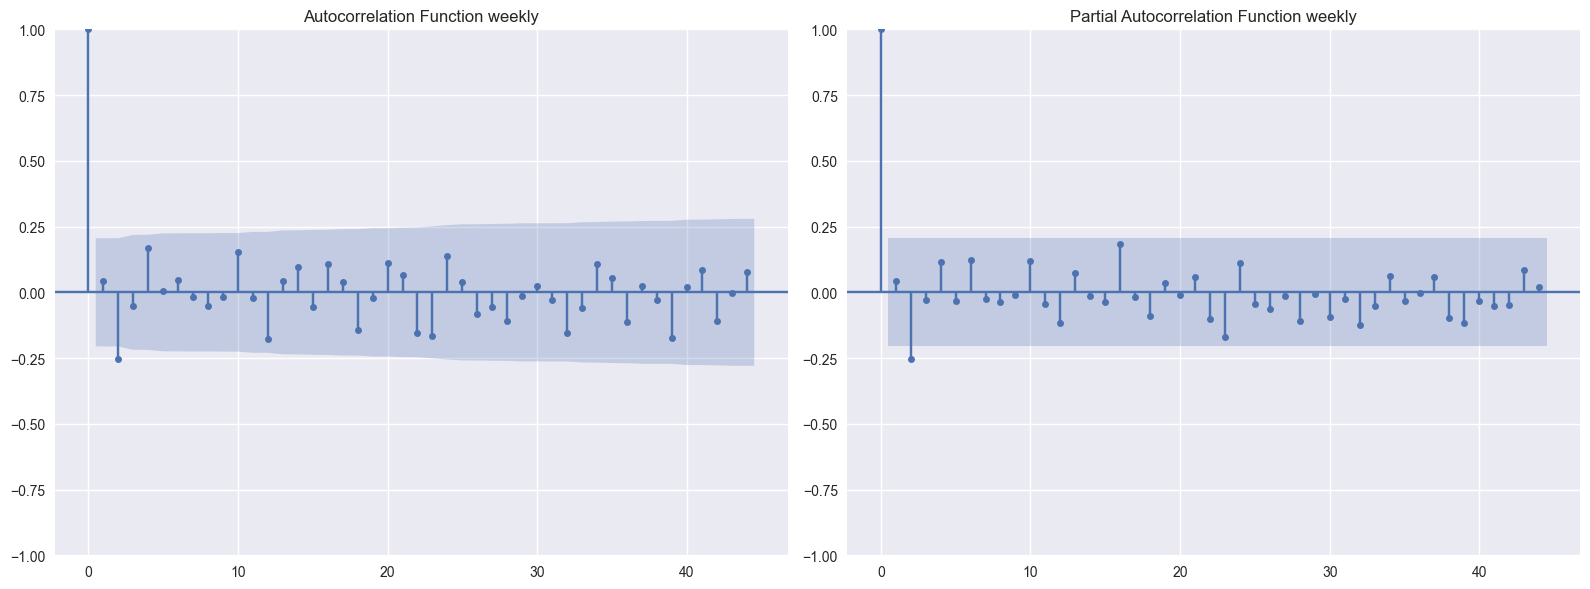

In [49]:
# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot ACF
plot_acf(train_data_diff52_w, lags=44, ax=ax[0])
ax[0].set_title('Autocorrelation Function weekly')

# Plot PACF
plot_pacf(train_data_diff52_w, lags=44, ax=ax[1], method='ywm')
ax[1].set_title('Partial Autocorrelation Function weekly')

# Show the plots
plt.tight_layout()
plt.show()

We can not get more than 44 lags for the PACF.

For the manual SARIMA model we need some parameters that we can derive from the ACF and PACF plot. The parameters are: order = (p,d,q); seasonal_order = (P,D,Q,S). 

* we first look at the non-seasonal part, verifying the significant spikes occurring in the two plots before lag 52 (44 actually). If we select ACF, the significant spikes suggest a non-seasonal MA(1) component. In the PACF, we select a non-seasonal AR(1) component. d is equal to 0, we did not do some difference in the non-seasonal.

* for the seasonal part we wonna use the Grid search to find out P and Q. D is equal to 1 and S is equal to 52.

In [50]:
# Predefined non-seasonal parameters
p = 1
d = 0
q = 1

# Predefined seasonal parameters
D = 1
S = 52

best_aic = math.inf
best_Q = 0
best_P = 0

# Define reduced ranges for P and Q
P_range = range(0, 5)
Q_range = range(0, 5)

<h5><b>Grid search</b></h5>

In [126]:
#Grid search

for P in P_range:
    for Q in Q_range:
        try:
            # Fit SARIMA model
            model = SARIMAX(train_data_w, 
                            order=(p, d, q), 
                            seasonal_order=(P, D, Q, S), 
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            result = model.fit(disp=False)
            
            # Check model criteria
            if result.aic < best_aic and (not np.isnan(result.bic) and not np.isnan(result.hqic)):
                best_aic = result.aic
                best_Q = Q
                best_P = P
                
                print(f'Current best model: Seasonal order ({P}, {D}, {Q}, {S}), AIC: {best_aic}')
                
        except Exception as e:
            continue

print(f'Best SARIMA parameters: Seasonal order ({best_P}, {D}, {best_Q}, {S}), AIC: {best_aic}')

Current best model: Seasonal order (0, 1, 0, 52), AIC: 2379.6760349161536
Current best model: Seasonal order (0, 1, 1, 52), AIC: 993.8214868443126
Current best model: Seasonal order (1, 1, 1, 52), AIC: 986.009966052442
Best SARIMA parameters: Seasonal order (1, 1, 1, 52), AIC: 986.009966052442


In [51]:
best_P = 1
best_Q = 1

<h5><b>Model</b></h5>

                                     SARIMAX Results                                      
Dep. Variable:             wind_generation_actual   No. Observations:                  143
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -1211.457
Date:                            Wed, 10 Jul 2024   AIC                           2432.914
Time:                                    12:16:43   BIC                           2445.468
Sample:                                01-01-2017   HQIC                          2437.979
                                     - 09-22-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1149      0.427     -0.269      0.788      -0.951       0.721
ma.L1          0.3623      0.393   

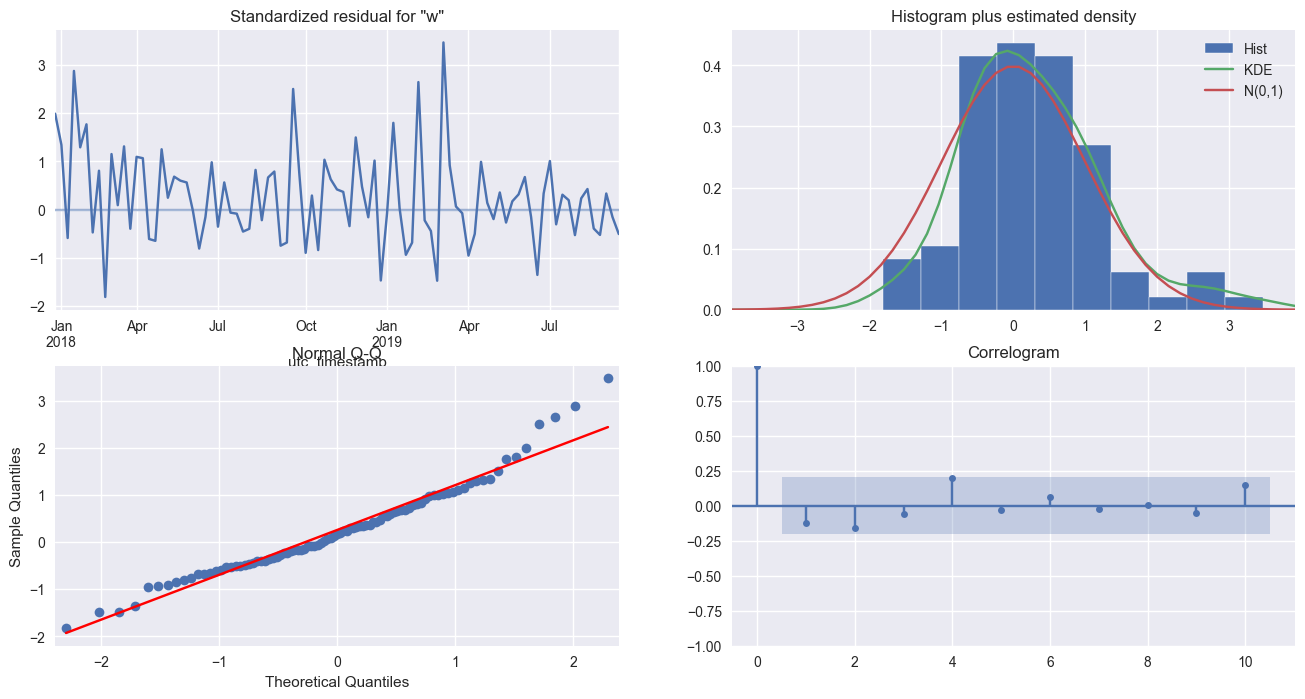

In [52]:
# Fit the SARIMA model
best_manual_Sarima_model = SARIMAX(train_data_w, 
                                   order=(p, d, q), 
                                   seasonal_order=(best_P, D, best_Q, S), 
                                   enforce_stationarity=True,
                                   enforce_invertibility=False) 

result_best_manual_SARIMA = best_manual_Sarima_model.fit(disp=False)

print(result_best_manual_SARIMA.summary())
result_best_manual_SARIMA.plot_diagnostics(figsize=(16, 8));

<h5><b>Durbin-Watson</b></h5>

In [53]:
res_manual = result_best_manual_SARIMA.resid
durbin_watson(res_manual)

1.0050072988622492

This value indicates that there is a positive correlation between the residues. Maybe is not the best model.

<h5><b>Forecast</b></h5>

Text(0, 0.5, 'Wind Generation')

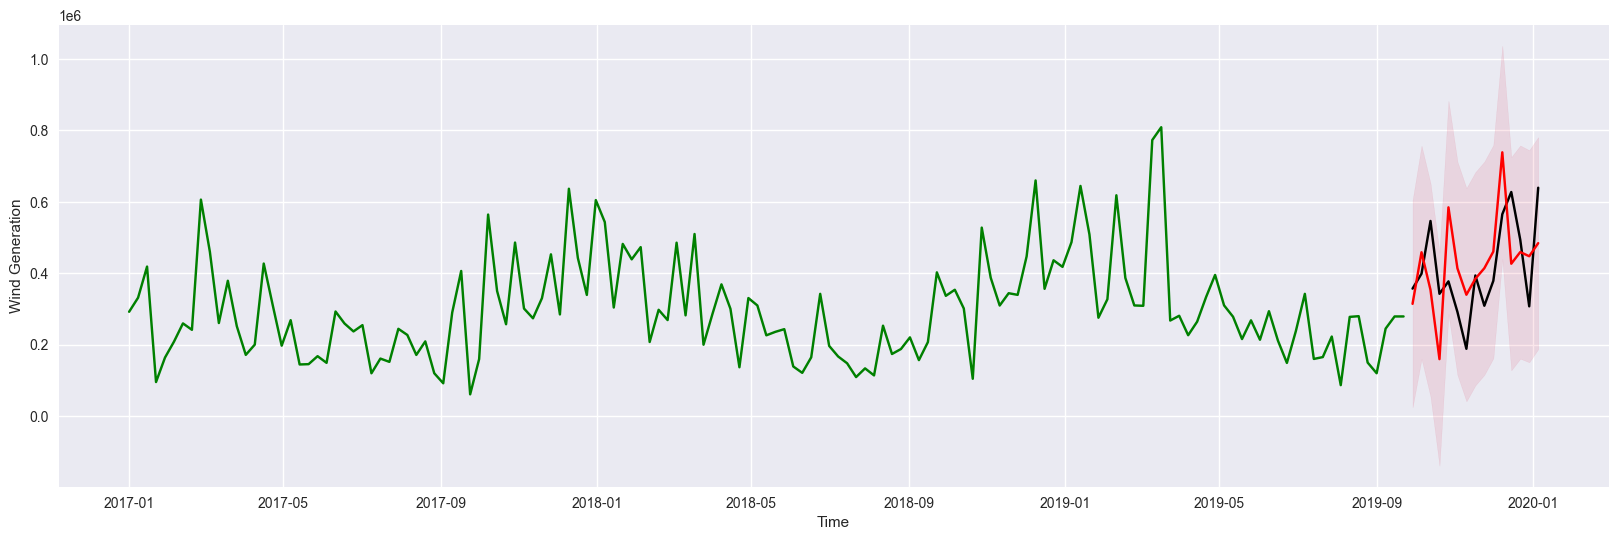

In [54]:
model_SARIMA = result_best_manual_SARIMA.get_prediction(start=test_data_w.index[0], end=test_data_w.index[-1])
Sarima = model_SARIMA.summary_frame()
plt.figure(figsize=(20, 6)) 
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(Sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(Sarima.index, Sarima['mean_ci_lower'], Sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% C.I.')
plt.xlabel('Time')
plt.ylabel('Wind Generation')

<h5><b>Zoom</b></h5>

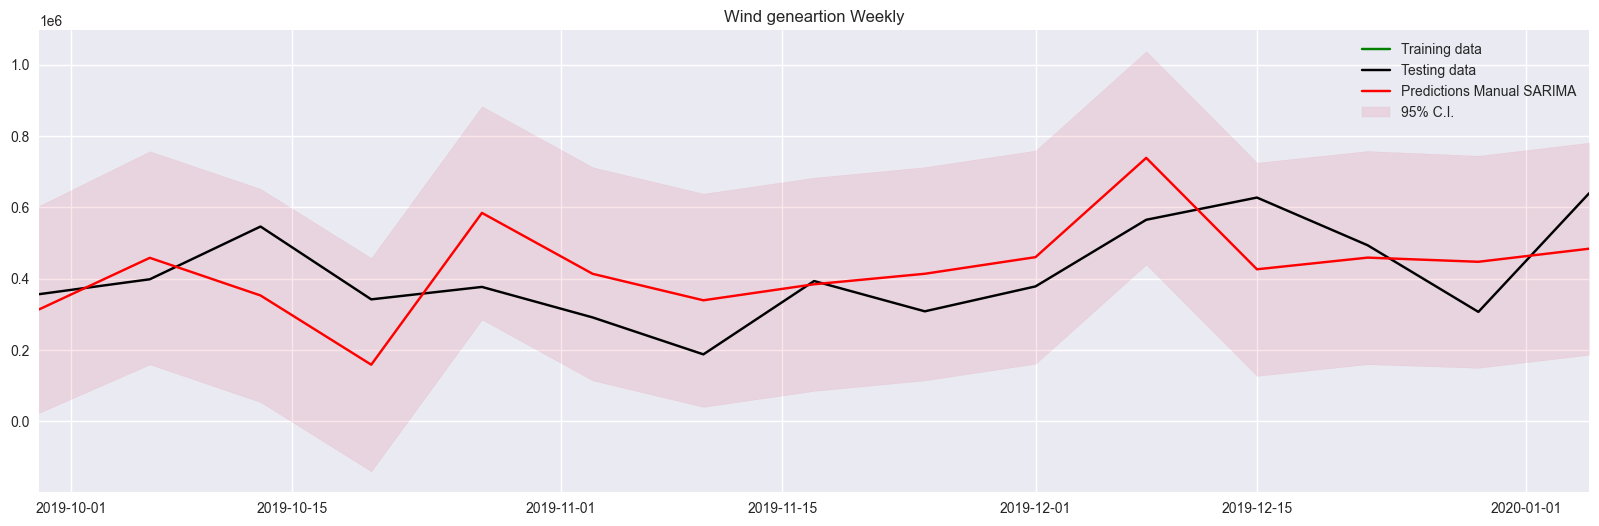

In [55]:
# Plot the data and predictions
plt.figure(figsize=(20, 6)) 
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(Sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(Sarima.index, Sarima['mean_ci_lower'], Sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% C.I.')

# Zoom into the prediction part
start_index = Sarima.index[-15]  # Start of zoom
end_index = Sarima.index[-1]      # End of zoom
plt.xlim(start_index, end_index)
plt.title('Wind geneartion Weekly')
plt.legend()
plt.show()

<h5><b>Metrics</b></h5>

In [190]:
Manual_SARIMA = {
    'Model_name': 'Manual SARIMA', 
    'AIC': result_best_manual_SARIMA.aic, 
    'BIC': result_best_manual_SARIMA.bic,
    'MAE': mean_absolute_error(test_data_w, Sarima['mean']), 
    'MAPE': mean_absolute_percentage_error(test_data_w, Sarima['mean']),
    'RMSE': mean_squared_error(test_data_w, Sarima['mean'], squared=False)
}
Manual_SARIMA

{'Model_name': 'Manual SARIMA',
 'AIC': 2432.913650753773,
 'BIC': 2445.467948286357,
 'MAE': 124055.52877824011,
 'MAPE': 0.3274393162674893,
 'RMSE': 139156.17279970634}

<h3><b>Auto SARIMA</b></h3>

Let's try the automatic SARIMA to find out another possibile choice of the parameters.

In [ ]:
# Auto ARIMA
stepwise_model = auto_arima(train_data_w, start_p=0, start_q=0, d=0,
                           max_p=3, max_q=3, m=52,
                           start_P=0, start_Q=0,max_P = 3, max_Q = 3, D = 1, seasonal=True,
                           trace=True, information_criterion='aicc',
                           error_action='ignore',
                           suppress_warnings=True,
                           n_jobs=4, # check the number of processors or cores of your computer that can be used in parallel during the model training process
                           stepwise=True) # stepwise = False will search for more models, increasing the computational time

After 27 minutes the best model is ARIMA(3,0,2)(1,1,0)[52]

In [164]:
(p, d, q) = (3,0,2)
(P, D, Q) = (1,1,0)
S = 52

<h5><b>Model</b></h5>

                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                  143
Model:             SARIMAX(3, 0, 2)x(1, 1, [], 52)   Log Likelihood               -1194.327
Date:                             Wed, 10 Jul 2024   AIC                           2402.654
Time:                                     16:33:50   BIC                           2420.230
Sample:                                 01-01-2017   HQIC                          2409.744
                                      - 09-22-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4857      0.244      6.083      0.000       1.007       1.964
ar.L2         -0.9261      

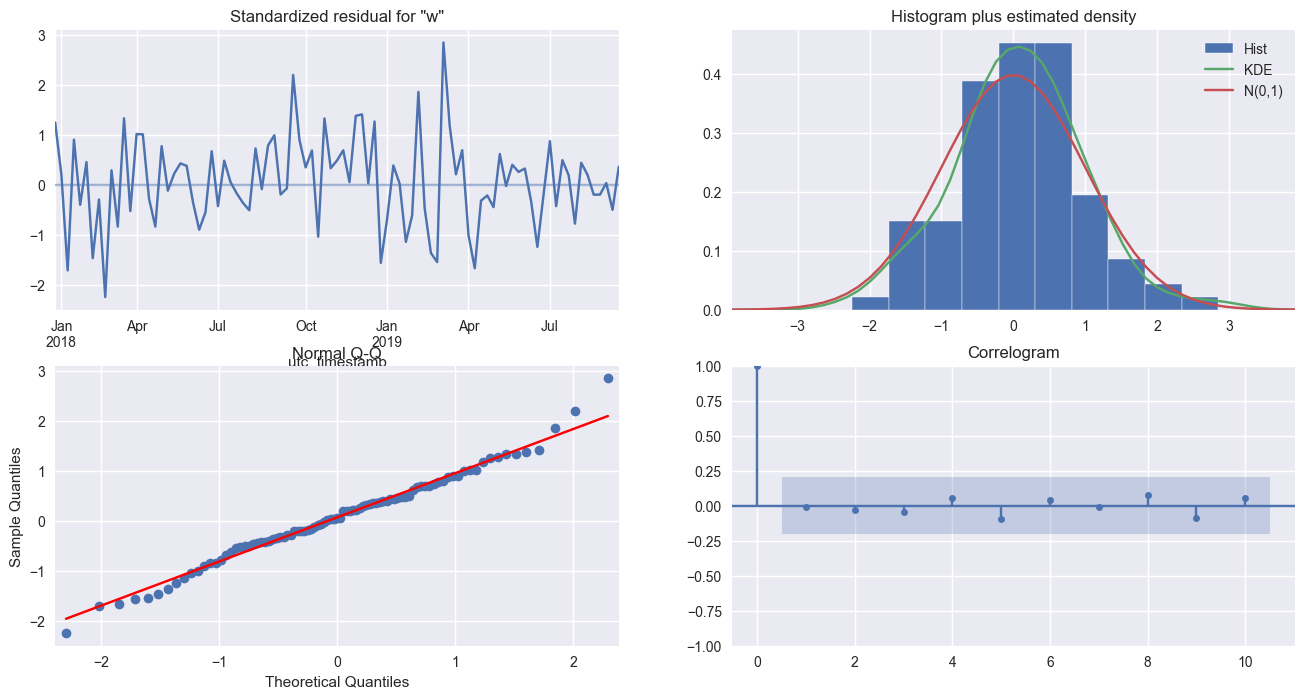

In [165]:
# Fit the SARIMA model
auto_Sarima_model = SARIMAX(train_data_w, 
                                   order=(p, d, q), 
                                   seasonal_order=(P, D, Q, S), 
                                   enforce_stationarity=True,
                                   enforce_invertibility=False) 

result_auto_SARIMA = auto_Sarima_model.fit(disp=False)

print(result_auto_SARIMA.summary())
result_auto_SARIMA.plot_diagnostics(figsize=(16, 8));

<h5><b>Durbin-Watson</b></h5>

In [166]:
res_auto = result_auto_SARIMA.resid
durbin_watson(res_auto)

1.365930576194563

<h5><b>Prediction</b></h5>

Text(0, 0.5, 'Wind Generation')

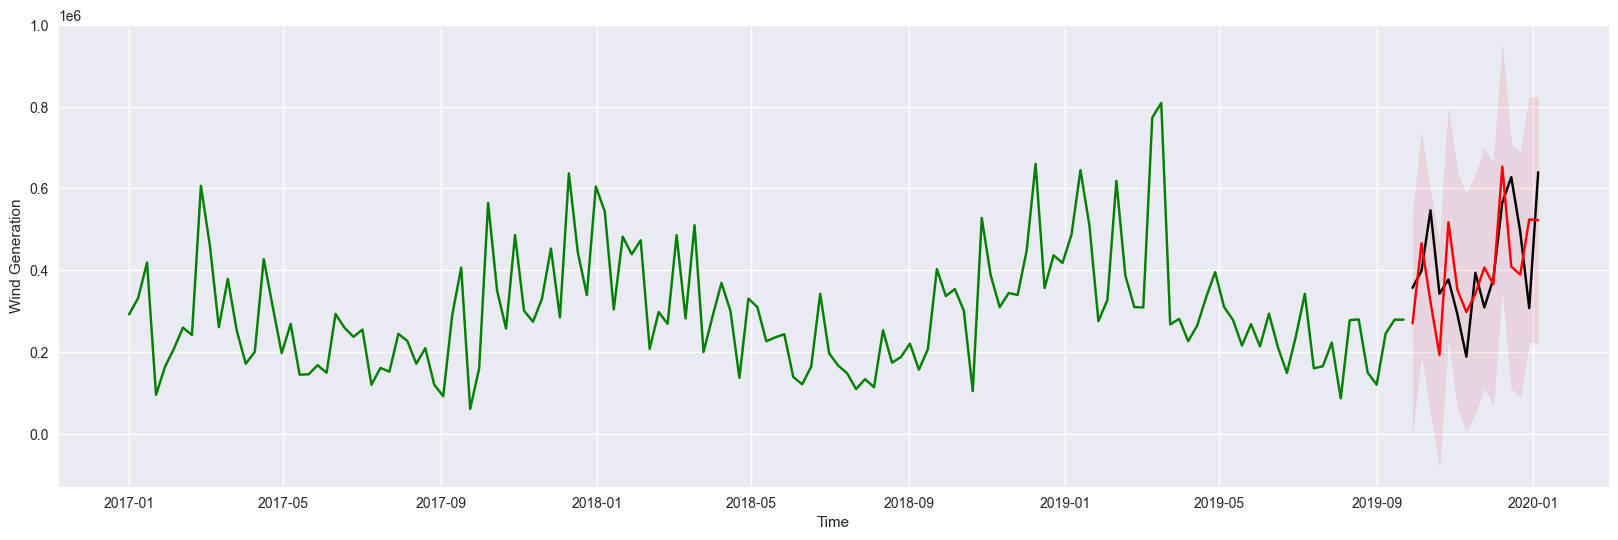

In [167]:
model_SARIMA = result_auto_SARIMA.get_prediction(start=test_data_w.index[0], end=test_data_w.index[-1])
Auto_Sarima = model_SARIMA.summary_frame()
plt.figure(figsize=(20, 6)) 
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(Auto_Sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(Auto_Sarima.index, Auto_Sarima['mean_ci_lower'], Auto_Sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% C.I.')
plt.xlabel('Time')
plt.ylabel('Wind Generation')

<h5><b>Zoom</b></h5>

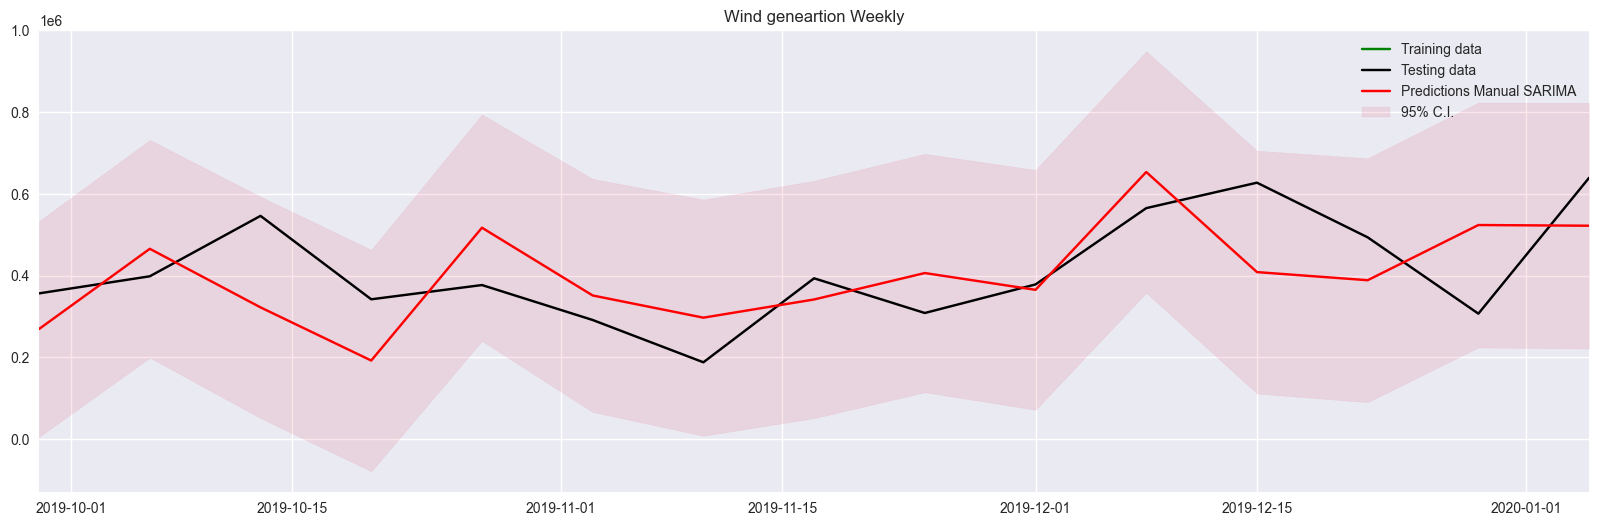

In [168]:
# Plot the data and predictions
plt.figure(figsize=(20, 6)) 
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(Auto_Sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(Auto_Sarima.index, Auto_Sarima['mean_ci_lower'], Auto_Sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% C.I.')

# Zoom into the prediction part
start_index = Auto_Sarima.index[-15]  # Start of zoom
end_index = Auto_Sarima.index[-1]      # End of zoom
plt.xlim(start_index, end_index)
plt.title('Wind geneartion Weekly')
plt.legend()
plt.show()

<h5><b>Metrics</b></h5>

In [191]:
Auto_SARIMA = {
    'Model_name': 'Auto SARIMA', 
    'AIC': result_auto_SARIMA.aic, 
    'BIC': result_auto_SARIMA.bic,
    'MAE': mean_absolute_error(test_data_w, Auto_Sarima['mean']), 
    'MAPE': mean_absolute_percentage_error(test_data_w, Auto_Sarima['mean']),
    'RMSE': mean_squared_error(test_data_w, Auto_Sarima['mean'], squared=False)
}
Auto_SARIMA

{'Model_name': 'Auto SARIMA',
 'AIC': 2402.653514816463,
 'BIC': 2420.229531362081,
 'MAE': 116402.34857969376,
 'MAPE': 0.3005878184018225,
 'RMSE': 131560.95258359585}

Until now this is the best model.

<h3><b>SARIMAX</b></h3>

There are other two features in the dataset that we can use to get a better forecasting. Exogenous variables are integrated into the ARIMA model to improve predictive ability, providing additional information that could explain variability in the main time series. The use of exogenous variables can lead to a more robust model and more accurate predictions, especially if exogenous variables are strongly correlated with the time series being modeled.

<h4><b>Exogenous variables</b></h4>

In [170]:
#Wind Capacity
wind_capacity_weekly = Wind_df['wind_capacity']
wind_capacity_weekly = wind_capacity_weekly.resample("W").mean()
wind_capacity_weekly_train = wind_capacity_weekly[:-15]
wind_capacity_weekly_test = wind_capacity_weekly[-15:]

#Temperature
temperature_weekly = Wind_df['temperature']
temperature_weekly = temperature_weekly.resample("W").mean()
temperature_weekly_train = temperature_weekly[:-15]
temperature_weekly_test = temperature_weekly[-15:]

<h5><b>Wind Capacity</b></h5>

In [171]:
wind_var_train = pd.concat([wind_capacity_weekly_train], axis=1)
wind_var_train.index = wind_capacity_weekly[:-15].index
wind_var_test = pd.concat([wind_capacity_weekly_test], axis=1)
wind_var_test.index = wind_capacity_weekly_test.index

In [34]:
# Best model
arima_model_wind = auto_arima(train_data_w, wind_var_train,  start_p=0, start_q=0, d=0,
                           max_p=3, max_q=3, m=52,
                           start_P=0, start_Q=0, max_P = 3, max_Q = 3, D = 1, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',  
                           suppress_warnings=True, 
                           n_jobs=4,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2434.415, Time=0.38 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2413.319, Time=10.43 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=10.45 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2752.928, Time=0.25 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=2436.157, Time=0.48 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=2414.851, Time=22.44 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=2414.875, Time=10.13 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=2415.332, Time=6.45 sec
 ARIMA(1,0,0)(2,1,1)[52] intercept   : AIC=2416.850, Time=33.93 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=2414.859, Time=4.11 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=2412.016, Time=7.65 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=2433.721, Time=0.75 sec
 ARIMA(2,0,0)(2,1,0)[52] intercept   : AIC=2413.810, Time=14.95 sec
 ARIMA(2,0,0)(1,1,1)[52] intercept   : AIC=2413.826, Time=11.95 sec
 ARIMA(2,0,0)(0,1

The best model is ARIMA(3,0,1)(1,1,0)[52] after 12 minutes of computing.

In [178]:
(p, d, q ) = (3,0,1)
(P, D, Q) = (1,1,0) 
S = 52

<h5><b>Model</b></h5>

                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                  143
Model:             SARIMAX(3, 0, 1)x(1, 1, [], 52)   Log Likelihood               -1194.719
Date:                             Wed, 10 Jul 2024   AIC                           2403.439
Time:                                     16:38:28   BIC                           2421.015
Sample:                                 01-01-2017   HQIC                          2410.530
                                      - 09-22-2019                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
wind_capacity     4.8851      2.905      1.681      0.093      -0.809      10.579
ar.L1             

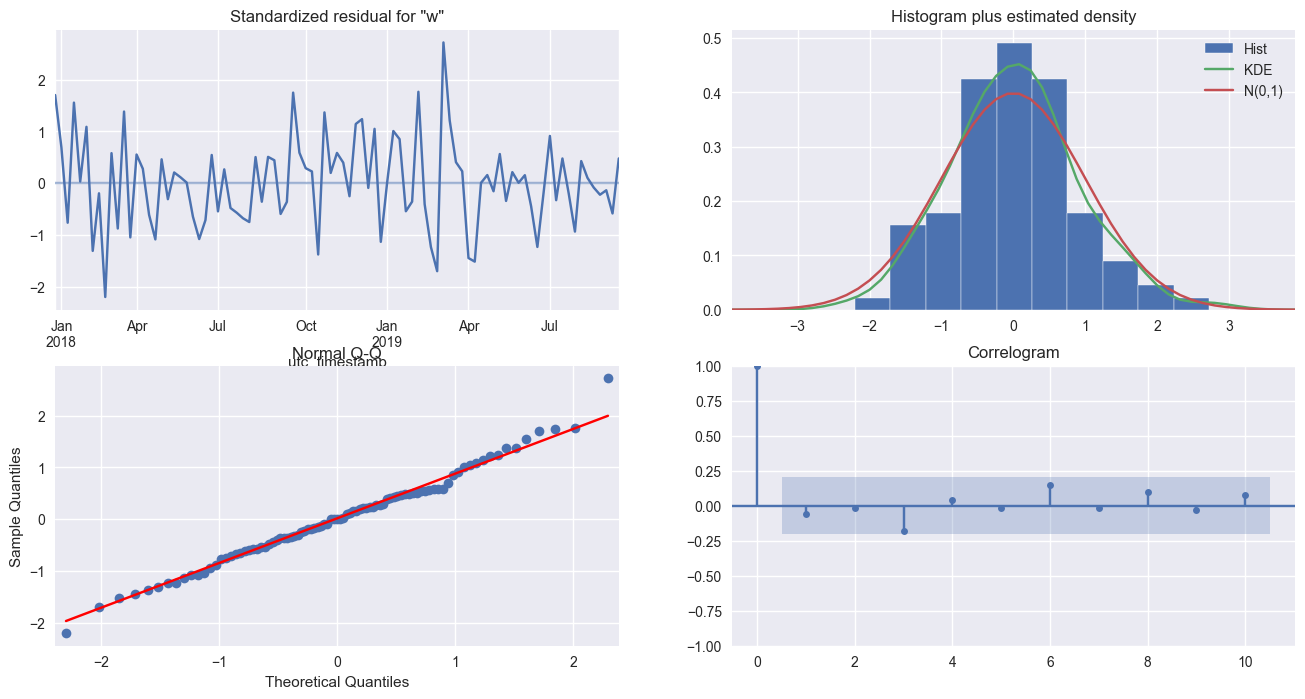

In [179]:
# Fit the SARIMA model
model_SARIMA = SARIMAX(train_data_w, exog=wind_var_train, 
                                   order=(p, d, q), 
                                   seasonal_order=(P, D, Q, S), 
                                   enforce_stationarity=True,
                                   enforce_invertibility=False) 

result_SARIMA_exog_wind = model_SARIMA.fit(disp=False)

print(result_SARIMA_exog_wind.summary())
result_SARIMA_exog_wind.plot_diagnostics(figsize=(16, 8));

<h5><b>Durbin-Watson</b></h5>

In [180]:
res_wind = result_SARIMA_exog_wind.resid
durbin_watson(res_wind)

1.8072946867036064

<h5><b>Prediction</b></h5>

Text(0, 0.5, 'Wind Generation')

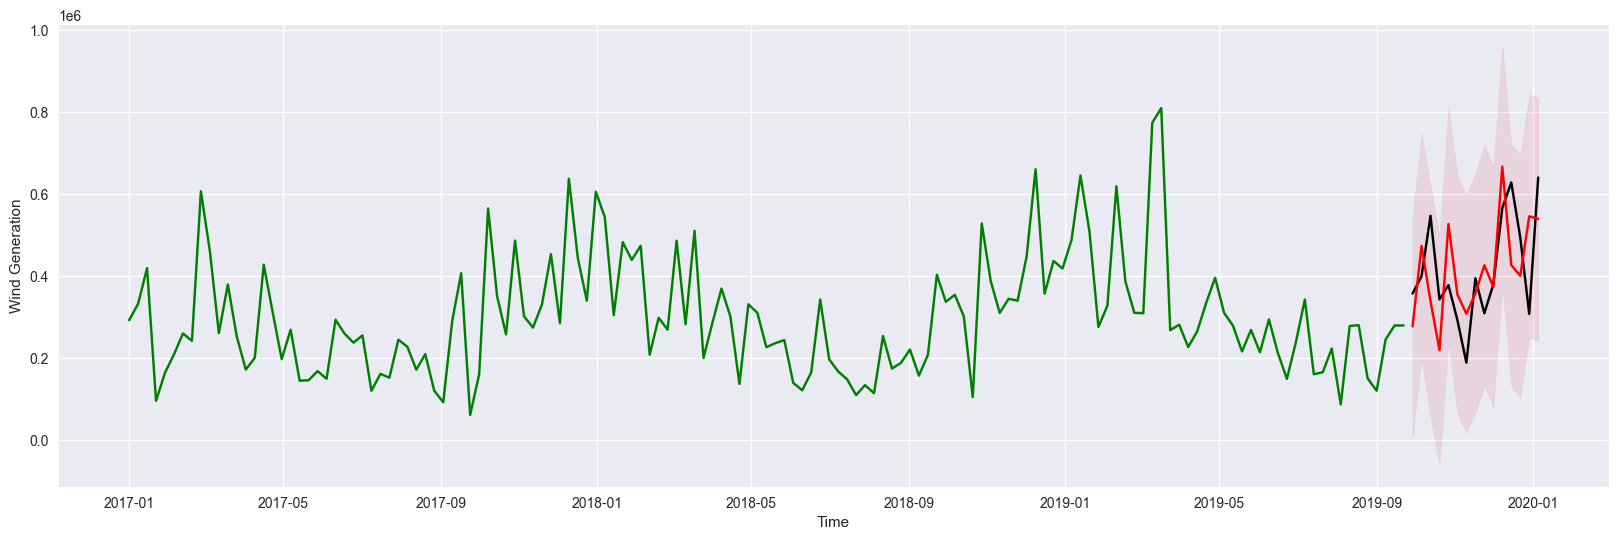

In [181]:
model_SARIMA_exog_wind = result_SARIMA_exog_wind.get_prediction(start=test_data_w.index[0], end=test_data_w.index[-1], exog=wind_var_test)
exog_wind_Sarima = model_SARIMA_exog_wind.summary_frame()
plt.figure(figsize=(20, 6)) 
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(exog_wind_Sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(exog_wind_Sarima.index, exog_wind_Sarima['mean_ci_lower'], exog_wind_Sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% C.I.')
plt.xlabel('Time')
plt.ylabel('Wind Generation')

<h5><b>Zoom</b><h5>

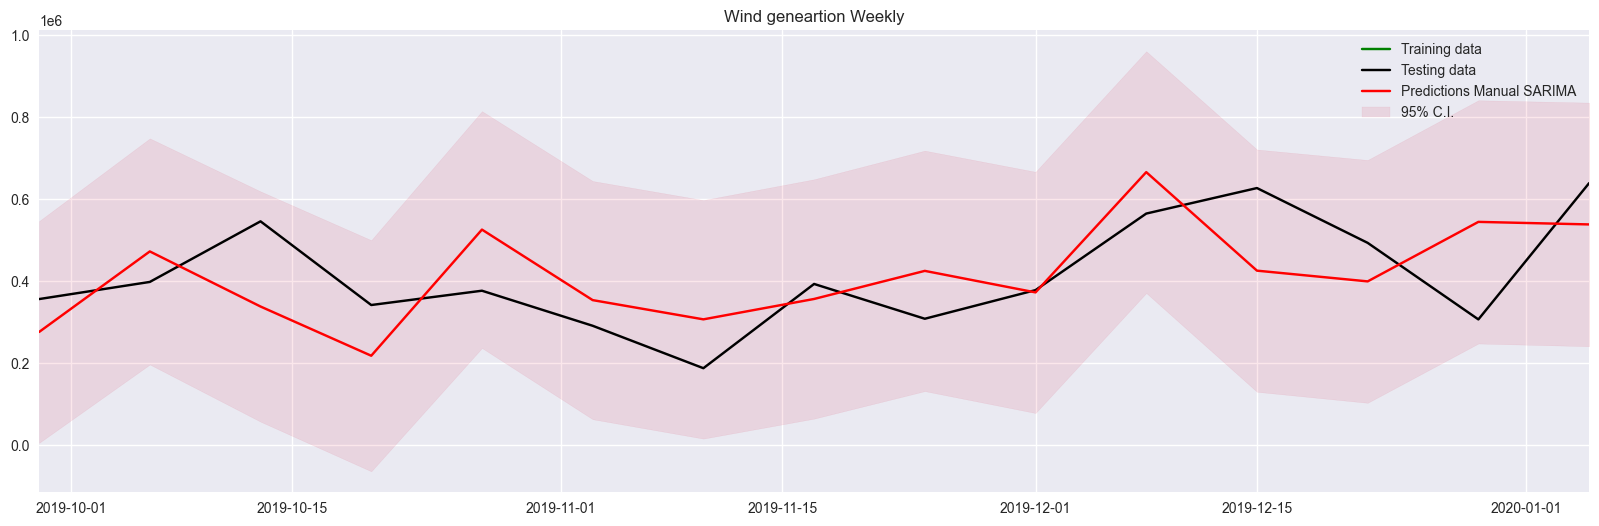

In [182]:
# Plot the data and predictions
plt.figure(figsize=(20, 6)) 
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(exog_wind_Sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(exog_wind_Sarima.index, exog_wind_Sarima['mean_ci_lower'], exog_wind_Sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% C.I.')

# Zoom into the prediction part
start_index = exog_wind_Sarima.index[-15]  # Start of zoom
end_index = exog_wind_Sarima.index[-1]      # End of zoom
plt.xlim(start_index, end_index)
plt.title('Wind geneartion Weekly')
plt.legend()
plt.show()

<h5><b>Metrics</b><h5>

In [192]:
Exog_wind_Sarima = {
    'Model_name': 'Exog wind SARIMA', 
    'AIC': result_SARIMA_exog_wind.aic, 
    'BIC': result_SARIMA_exog_wind.bic,
    'MAE': mean_absolute_error(test_data_w, exog_wind_Sarima['mean']), 
    'MAPE': mean_absolute_percentage_error(test_data_w, exog_wind_Sarima['mean']),
    'RMSE': mean_squared_error(test_data_w, exog_wind_Sarima['mean'], squared=False)
}
Exog_wind_Sarima

{'Model_name': 'Exog wind SARIMA',
 'AIC': 2403.4387292988986,
 'BIC': 2421.0147458445167,
 'MAE': 114050.19260622331,
 'MAPE': 0.30037307867489665,
 'RMSE': 129635.4583576982}

<h5><b>Temperature</b></h5>

In [71]:
temp_var_train = pd.concat([temperature_weekly_train], axis=1)
temp_var_train.index = wind_capacity_weekly[:-15].index
temp_var_test = pd.concat([temperature_weekly_test], axis=1)
temp_var_test.index = temperature_weekly_test.index

In [36]:
arima_model_temp = auto_arima(train_data_w, temp_var_train,  start_p=0, start_q=0, d=0,
                           max_p=3, max_q=3, m=52,
                           start_P=0, start_Q=0, max_P = 3, max_Q = 3, D = 1, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',  
                           suppress_warnings=True, 
                           n_jobs=4,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2432.976, Time=0.21 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2424.542, Time=4.49 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2424.425, Time=4.95 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2755.152, Time=0.15 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=2434.715, Time=0.32 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=13.00 sec
 ARIMA(0,0,1)(0,1,2)[52] intercept   : AIC=2425.684, Time=9.21 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=2425.446, Time=4.17 sec
 ARIMA(0,0,1)(1,1,2)[52] intercept   : AIC=inf, Time=22.43 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=2426.081, Time=3.58 sec
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=2420.020, Time=7.63 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=2436.143, Time=0.73 sec
 ARIMA(1,0,1)(1,1,1)[52] intercept   : AIC=2420.725, Time=14.25 sec
 ARIMA(1,0,1)(0,1,2)[52] intercept   : AIC=2421.411, Time=16.50 sec
 ARIMA(1,0,1)(1,1,0)[52] 

Best model ARIMA(3,0,2)(1,1,0)[52] with 41 minutes of computational time.

In [72]:
(p, d, q ) = (3,0,2)
(P, D, Q) = (1,1,0) 
S = 52

<h5><b>Model</b></h5>

                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                  143
Model:             SARIMAX(3, 0, 2)x(1, 1, [], 52)   Log Likelihood               -1194.517
Date:                             Wed, 10 Jul 2024   AIC                           2405.034
Time:                                     12:21:11   BIC                           2425.120
Sample:                                 01-01-2017   HQIC                          2413.137
                                      - 09-22-2019                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
temperature  4931.3116   3764.741      1.310      0.190   -2447.445    1.23e+04
ar.L1           1.5472  

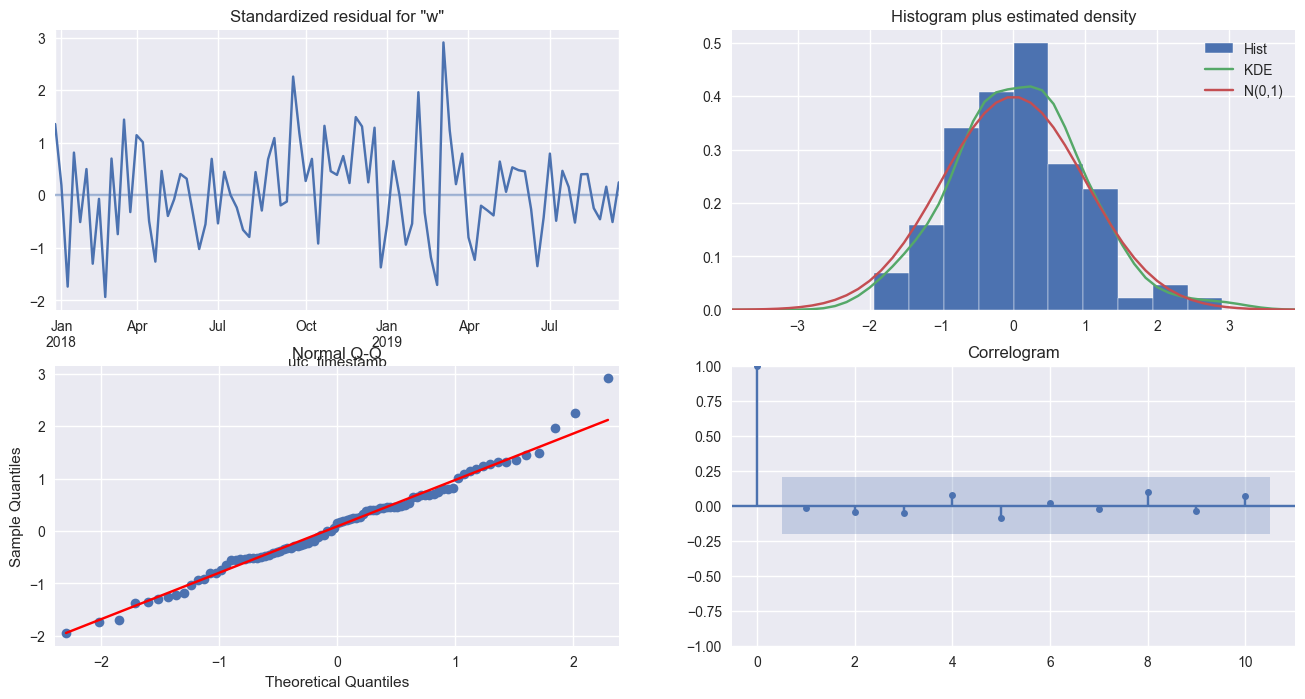

In [73]:
# Fit the SARIMA model
model_SARIMA = SARIMAX(train_data_w, exog=temp_var_train, 
                                   order=(p, d, q), 
                                   seasonal_order=(P, D, Q, S), 
                                   enforce_stationarity=True,
                                   enforce_invertibility=False) 

result_SARIMA_exog_temp = model_SARIMA.fit(disp=False)

print(result_SARIMA_exog_temp.summary())
result_SARIMA_exog_temp.plot_diagnostics(figsize=(16, 8));

<h5><b>Durbin-Watson</b></h5>

In [74]:
res_temp = result_SARIMA_exog_temp.resid
durbin_watson(res_temp)

1.2774159692109441

<h5><b>Prediction</b></h5>

Text(0, 0.5, 'Wind Generation')

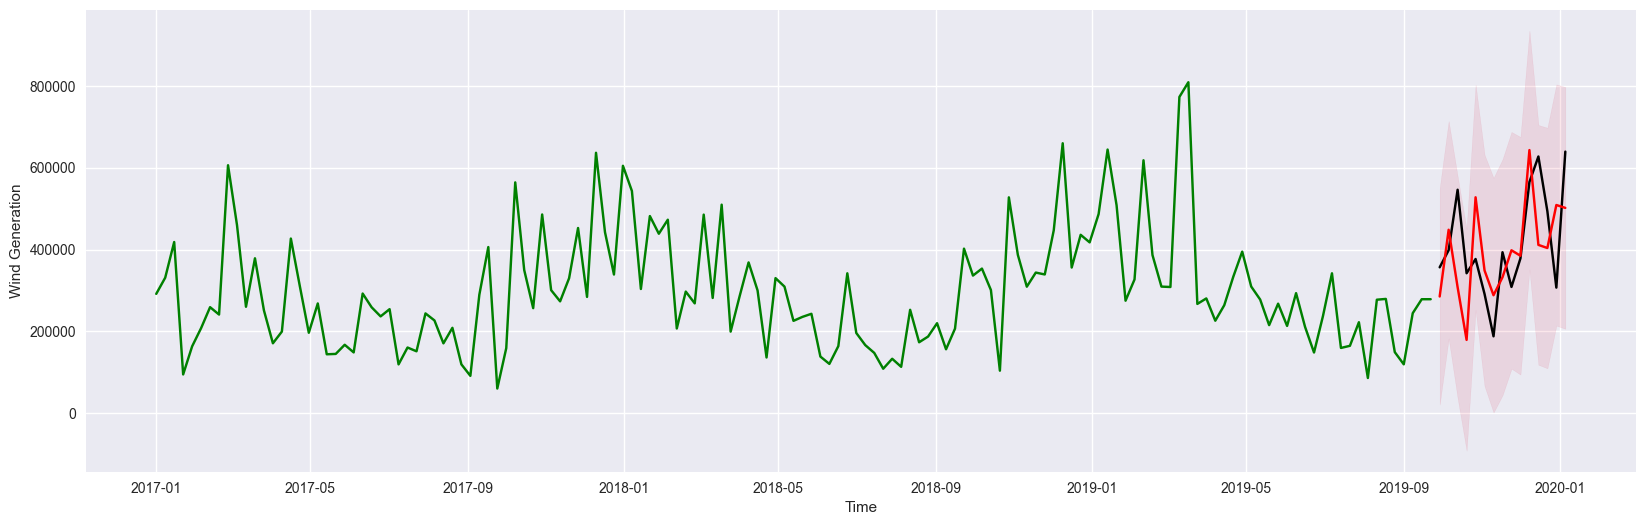

In [75]:
model_SARIMA_exog_temp = result_SARIMA_exog_temp.get_prediction(start=test_data_w.index[0], end=test_data_w.index[-1], exog=temp_var_test)
exog_temp_Sarima = model_SARIMA_exog_temp.summary_frame()
plt.figure(figsize=(20, 6)) 
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(exog_temp_Sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(exog_temp_Sarima.index, exog_temp_Sarima['mean_ci_lower'], exog_temp_Sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% C.I.')
plt.xlabel('Time')
plt.ylabel('Wind Generation')

<h5><b>Zoom</b></h5>

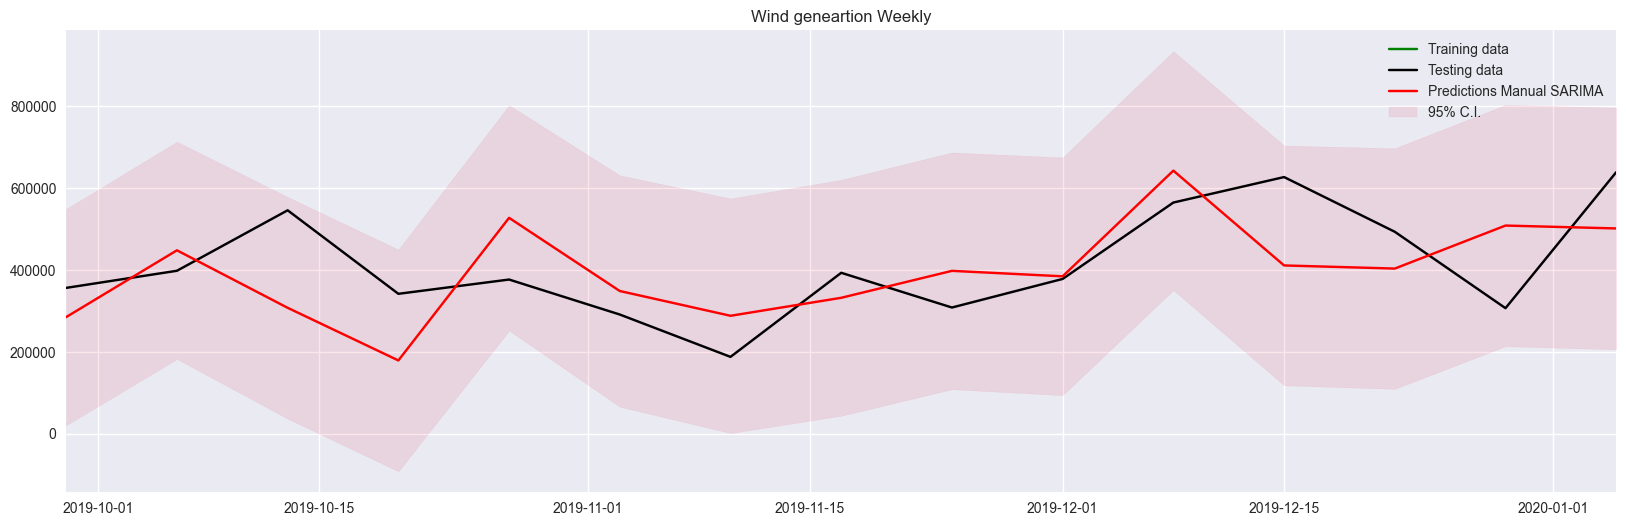

In [76]:
# Plot the data and predictions
plt.figure(figsize=(20, 6)) 
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(exog_temp_Sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(exog_temp_Sarima.index, exog_temp_Sarima['mean_ci_lower'], exog_temp_Sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% C.I.')

# Zoom into the prediction part
start_index = exog_temp_Sarima.index[-15]  # Start of zoom
end_index = exog_temp_Sarima.index[-1]      # End of zoom
plt.xlim(start_index, end_index)
plt.title('Wind geneartion Weekly')
plt.legend()
plt.show()

<h5><b>Metrics</b></h5>

In [193]:
Exog_temp_Sarima = {
    'Model_name': 'Exog temp SARIMA', 
    'AIC': result_SARIMA_exog_temp.aic, 
    'BIC': result_SARIMA_exog_temp.bic,
    'MAE': mean_absolute_error(test_data_w, exog_temp_Sarima['mean']), 
    'MAPE': mean_absolute_percentage_error(test_data_w, exog_temp_Sarima['mean']),
    'RMSE': mean_squared_error(test_data_w, exog_temp_Sarima['mean'], squared=False)
}
Exog_temp_Sarima

{'Model_name': 'Exog temp SARIMA',
 'AIC': 2405.0335749294163,
 'BIC': 2425.120450981551,
 'MAE': 114078.52836380413,
 'MAPE': 0.29116773257702094,
 'RMSE': 131454.63546457587}

<h4><b>Wind capacity and temperature</b></h4>

In [78]:
exog_var_train = pd.concat([temperature_weekly_train, wind_capacity_weekly_train], axis=1)
exog_var_train.index = wind_capacity_weekly[:-15].index
exog_var_test = pd.concat([temperature_weekly_test, wind_capacity_weekly_test], axis=1)
exog_var_test.index = wind_capacity_weekly_test.index

- AIC: If our main goal is to make future predictions; 
- BIC: If our main goal is to understand the relationship between the time series and exogenous variables.

In [78]:
# Best model
arima_model = auto_arima(y = train_data_w, X = exog_var_train,  start_p=0, start_q=0, d=0,
                           max_p=3, max_q=3, m=52,
                           start_P=0, start_Q=0, max_P = 3, max_Q = 3, D = 1, seasonal=True,
                           trace=True, information_criterion='aic', # I wanna make predictions
                           error_action='ignore', 
                           suppress_warnings=True, 
                           n_jobs=4,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=2435.323, Time=0.32 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=2418.574, Time=7.20 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=2417.784, Time=8.68 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=2753.857, Time=0.19 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=2437.289, Time=0.54 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=2418.070, Time=11.91 sec
 ARIMA(0,0,1)(0,1,2)[52] intercept   : AIC=2418.156, Time=18.58 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=2416.524, Time=8.21 sec
 ARIMA(0,0,1)(2,1,0)[52] intercept   : AIC=2418.052, Time=19.50 sec
 ARIMA(0,0,1)(2,1,1)[52] intercept   : AIC=2420.052, Time=39.77 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=2420.917, Time=5.10 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=2418.287, Time=14.97 sec
 ARIMA(0,0,2)(1,1,0)[52] intercept   : AIC=2417.344, Time=10.92 sec
 ARIMA(1,0,2)(1,1,0)[52] intercept   : AIC=2419.301, Time=13.20 sec
 ARIMA(0,0,1

The best model is ARIMA(0,0,1)(1,1,0)[52] with a computational time of 5 minutes.

In [79]:
(p, d, q ) = (0,0,1)
(P, D, Q) = (1,1,0) 
S = 52

<h5><b>Model</b></h5>

                                      SARIMAX Results                                      
Dep. Variable:              wind_generation_actual   No. Observations:                  143
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 52)   Log Likelihood               -1202.257
Date:                             Wed, 10 Jul 2024   AIC                           2414.513
Time:                                     12:26:09   BIC                           2427.068
Sample:                                 01-01-2017   HQIC                          2419.578
                                      - 09-22-2019                                         
Covariance Type:                               opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
temperature    3843.7175   4490.992      0.856      0.392   -4958.465    1.26e+04
wind_capacity     

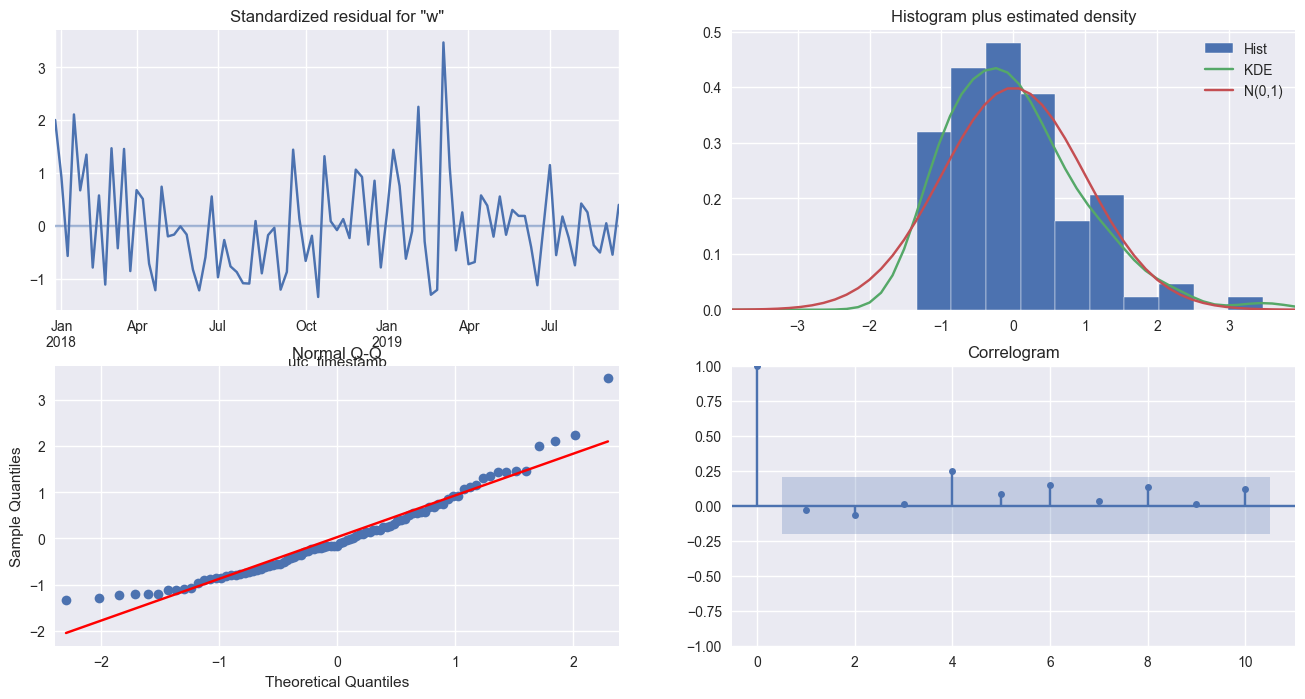

In [80]:
# Fit the SARIMA model
model_SARIMA = SARIMAX(train_data_w, exog=exog_var_train, 
                                   order=(p, d, q), 
                                   seasonal_order=(P, D, Q, S), 
                                   enforce_stationarity=True,
                                   enforce_invertibility=False) 

result_SARIMA_exog_both = model_SARIMA.fit(disp=False)

print(result_SARIMA_exog_both.summary())
result_SARIMA_exog_both.plot_diagnostics(figsize=(16, 8));

<h5><b>Durbin-Watson test</b></h5>

In [81]:
res_both = result_SARIMA_exog_both.resid
durbin_watson(res_both)

1.9091123200263862

<h5><b>Prediction</b></h5>

Text(0, 0.5, 'Wind Generation')

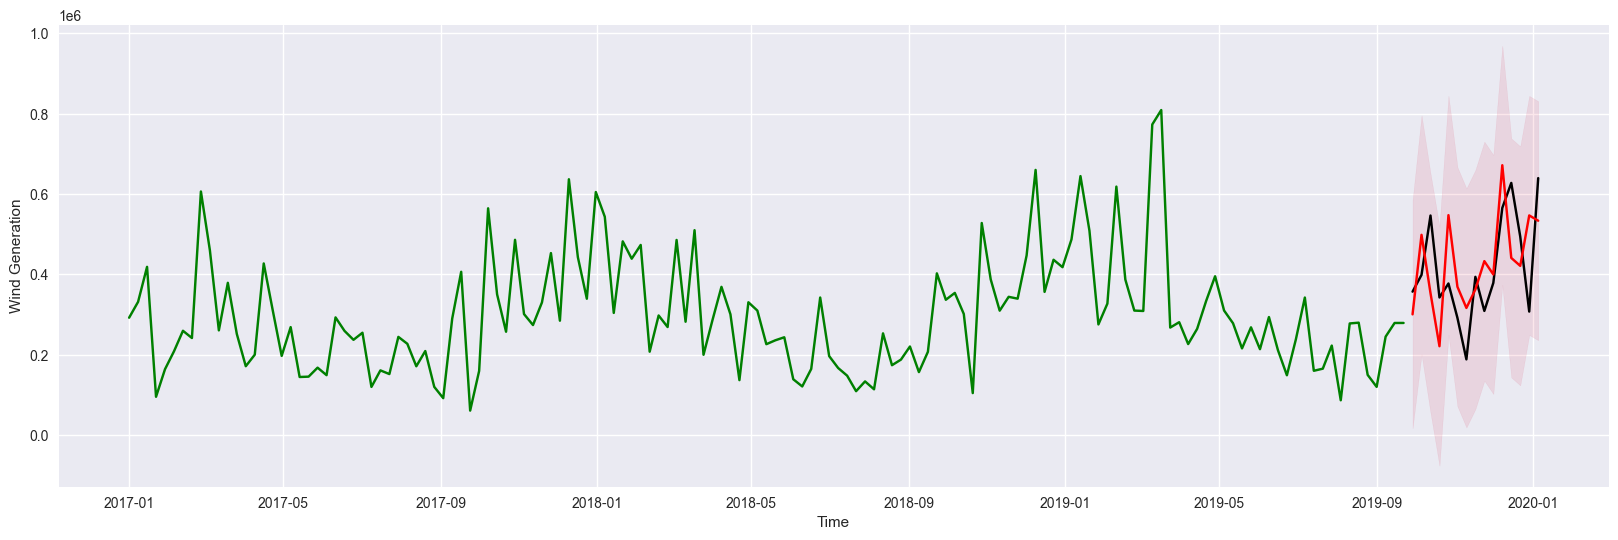

In [82]:
model_SARIMA_exog_both = result_SARIMA_exog_both.get_prediction(start=test_data_w.index[0], end=test_data_w.index[-1], exog=exog_var_test)
exog_both_Sarima = model_SARIMA_exog_both.summary_frame()
plt.figure(figsize=(20, 6)) 
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(exog_both_Sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(exog_both_Sarima.index, exog_both_Sarima['mean_ci_lower'], exog_both_Sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% C.I.')
plt.xlabel('Time')
plt.ylabel('Wind Generation')

<h5><b>Zoom</b><h5>

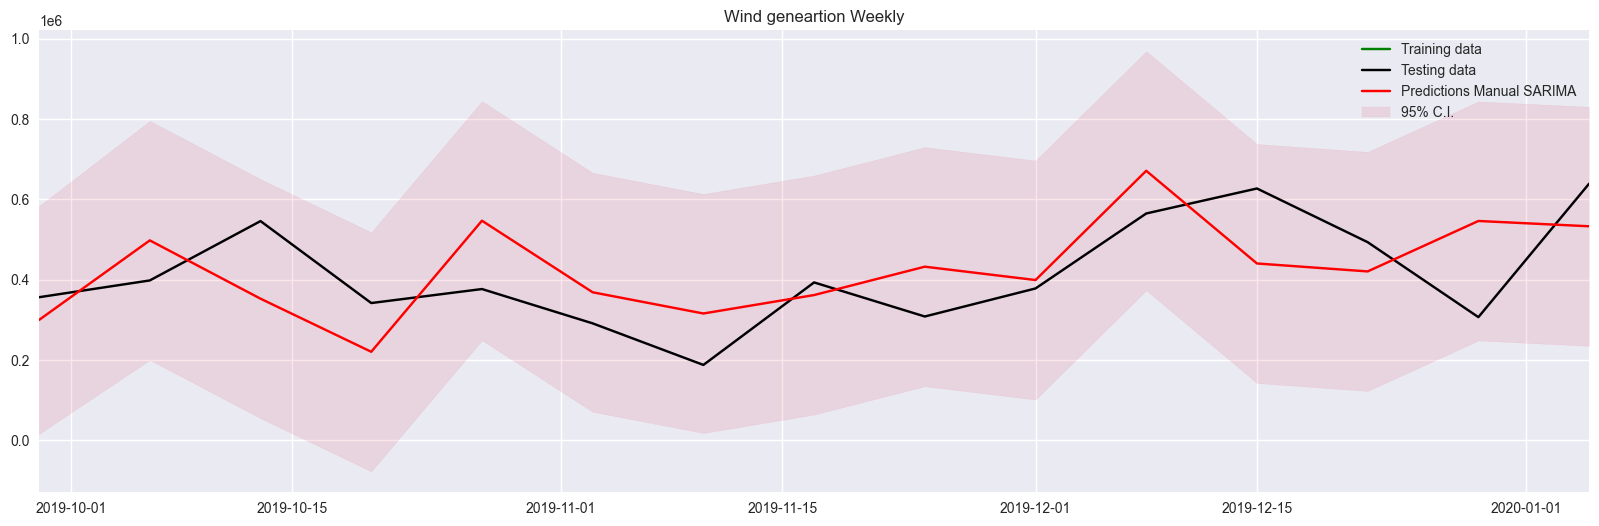

In [83]:
# Plot the data and predictions
plt.figure(figsize=(20, 6)) 
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(exog_both_Sarima['mean'], color='red', label='Predictions Manual SARIMA')
plt.fill_between(exog_both_Sarima.index, exog_both_Sarima['mean_ci_lower'], exog_both_Sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% C.I.')

# Zoom into the prediction part
start_index = exog_both_Sarima.index[-15]  # Start of zoom
end_index = exog_both_Sarima.index[-1]      # End of zoom
plt.xlim(start_index, end_index)
plt.title('Wind geneartion Weekly')
plt.legend()
plt.show()

<h5><b>Metrics</b></h5>

In [194]:
Exog_both_Sarima = {
    'Model_name': 'Exog both SARIMA', 
    'AIC': result_SARIMA_exog_both.aic, 
    'BIC': result_SARIMA_exog_both.bic,
    'MAE': mean_absolute_error(test_data_w, exog_both_Sarima['mean']), 
    'MAPE': mean_absolute_percentage_error(test_data_w, exog_both_Sarima['mean']),
    'RMSE': mean_squared_error(test_data_w, exog_both_Sarima['mean'], squared=False)
}
Exog_both_Sarima

{'Model_name': 'Exog both SARIMA',
 'AIC': 2414.513420127945,
 'BIC': 2427.0677176605295,
 'MAE': 115616.52205285469,
 'MAPE': 0.3087493200675396,
 'RMSE': 129978.87080956358}

<h3><b>ETS Weekly</b></h3>

For a fair comparison between the models I've decided to do the analysis on ETS using weekly data too. 

<h5><b>Model</b></h5>

In [85]:
model_ETS_weekly = ETSModel(train_data_w, trend='add', seasonal='add',seasonal_periods=52).fit(disp=False)
pred_ETS_weekly = model_ETS_weekly.get_prediction(start=test_data_w.index[0], end=test_data_w.index[-1])
df_ETS_weekly = pred_ETS_weekly.summary_frame()

<h5><b>Durbin-Watson</b></h5>

In [86]:
res_ETS_weekly = test_data_w - df_ETS_weekly['mean']
durbin_watson(res_ETS_weekly)

1.9021626079129674

<h5><b>Prediction</b></h5>

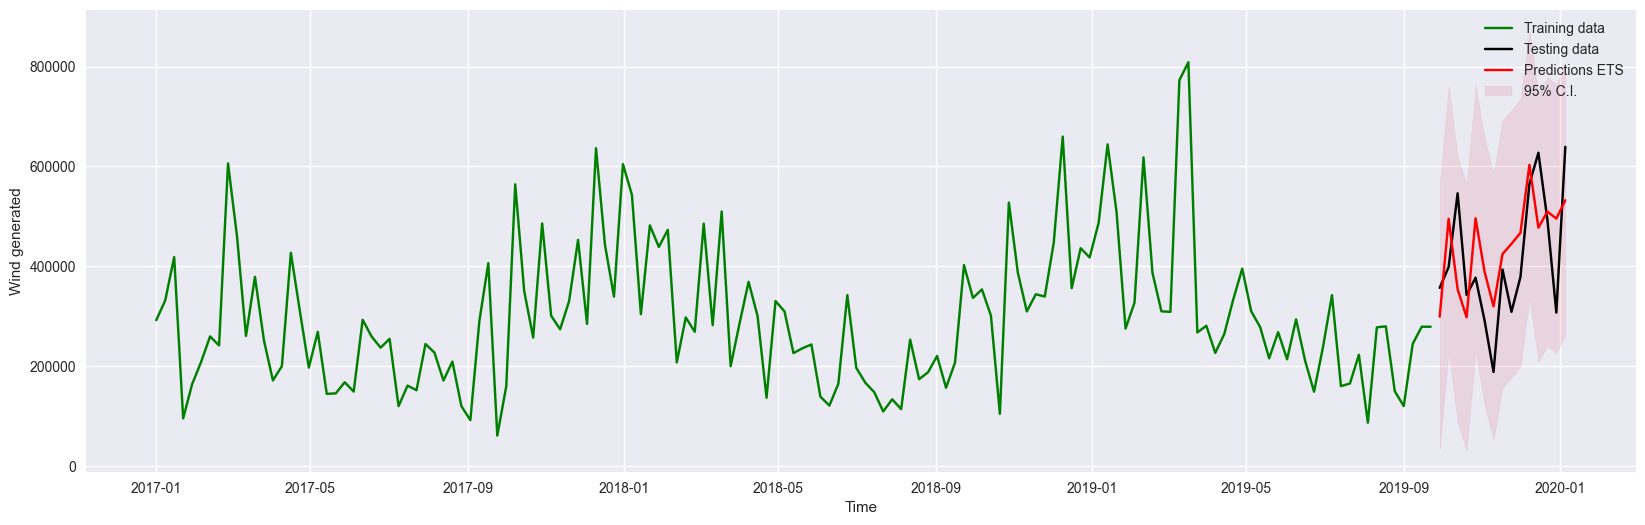

In [87]:
fig = plt.figure(figsize=(20,6))
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(df_ETS_weekly['mean'], color='red', label='Predictions ETS')
plt.fill_between(df_ETS_weekly.index, df_ETS_weekly['pi_lower'], df_ETS_weekly['pi_upper'], alpha=.1, color='crimson', label='95% C.I.') # Confidence interval
plt.xlabel('Time')
plt.ylabel('Wind generated')
plt.legend()

<h5><b>Zoom</b></h5>

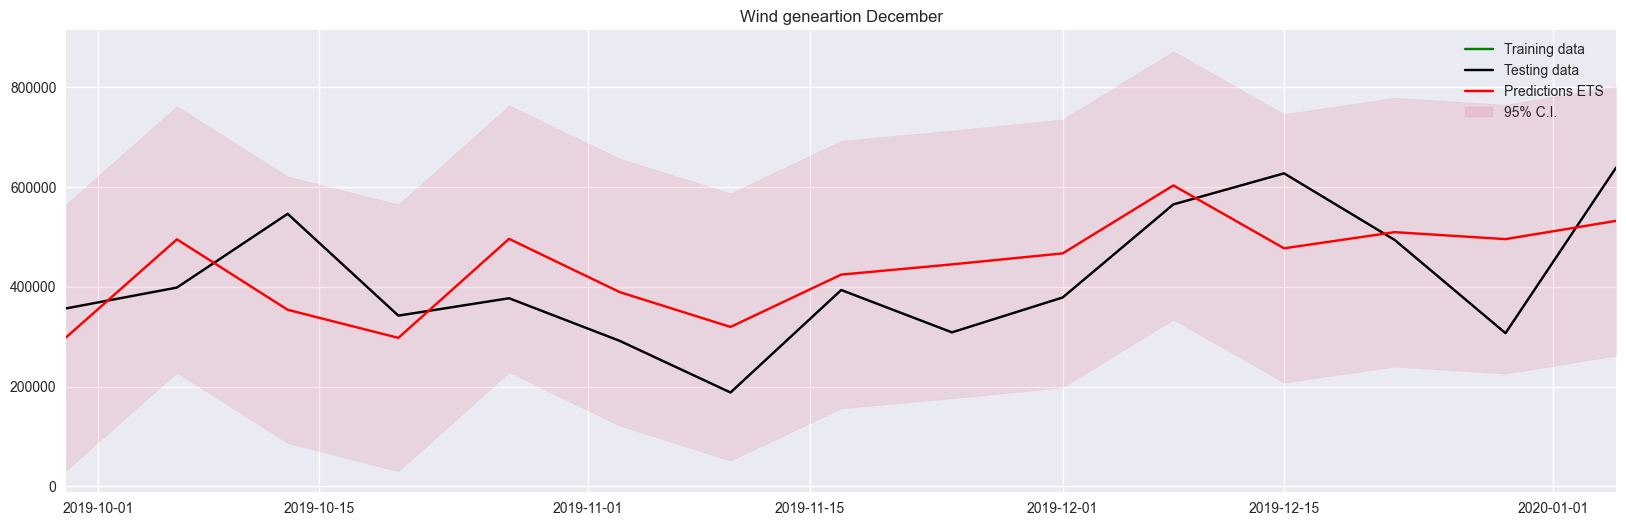

In [88]:
# Plot the data and predictions
fig = plt.figure(figsize=(20,6))
plt.plot(train_data_w, color='green',label='Training data')
plt.plot(test_data_w, color='black', label='Testing data')
plt.plot(df_ETS_weekly['mean'], color='red', label='Predictions ETS')
plt.fill_between(df_ETS_weekly.index, df_ETS_weekly['pi_lower'], df_ETS_weekly['pi_upper'], alpha=.1, color='crimson', label='95% C.I.') # Confidence interval

# Zoom into the prediction part
start_index = df_ETS_weekly.index[-15]  # Start of zoom
end_index = df_ETS_weekly.index[-1]      # End of zoom
plt.xlim(start_index, end_index)
plt.title('Wind geneartion December')
plt.legend()
plt.show()

<h5><b>Plots</b></h5>

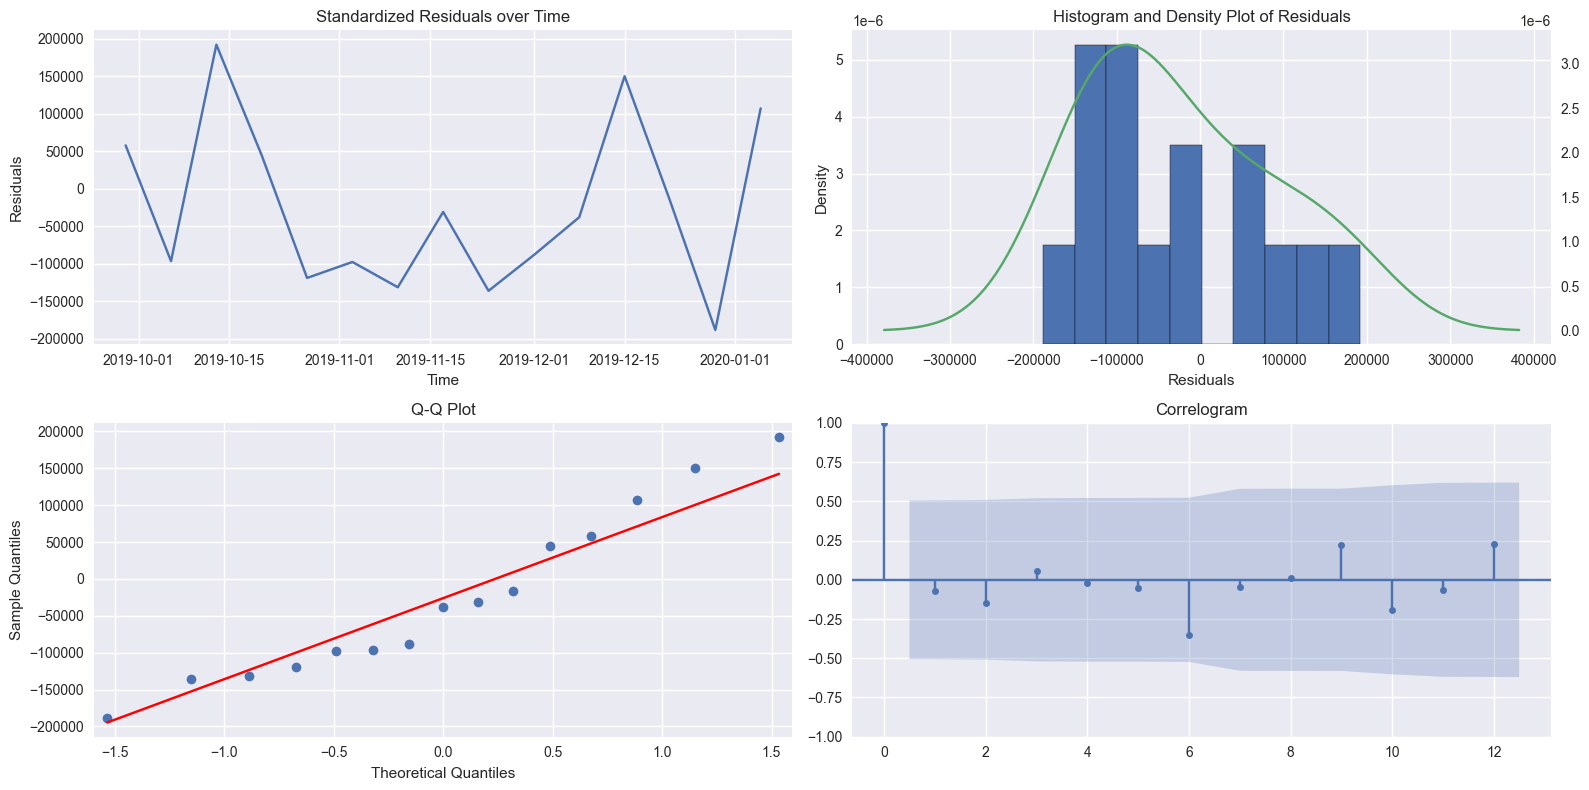

In [89]:
# PLots
residuals = test_data_w - df_ETS_weekly['mean']

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# 1. Standardized residuals over time
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Standardized Residuals over Time')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residuals')

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=10, edgecolor='black', density=True)
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')

# Adding KDE plot for histogram
residuals.plot(kind='kde', ax=axes[0, 1], secondary_y=True, title='Histogram and Density Plot of Residuals')

# 3. Q-Q plot of residuals
sm.qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, ax=axes[1, 1])
axes[1, 1].set_title('Correlogram')

plt.tight_layout()
plt.show()

<h5><b>Metrics</b></h5>

In [195]:
ets_weekly = {
    'Model_name': 'ETS Weekly', 
    'AIC': model_ETS_weekly.aic, 
    'BIC': model_ETS_weekly.bic,
    'MAE': mean_absolute_error(test_data_w, df_ETS_weekly['mean']), 
    'MAPE': mean_absolute_percentage_error(test_data_w, df_ETS_weekly['mean']),
    'RMSE': mean_squared_error(test_data_w, df_ETS_weekly['mean'], squared=False)
}
ets_weekly

{'Model_name': 'ETS Weekly',
 'AIC': 3902.8723488638743,
 'BIC': 4074.717337418949,
 'MAE': 99657.1641616105,
 'MAPE': 0.2740631144002388,
 'RMSE': 112923.02304514461}

The metrics are very good considering the models used until now.

<h3><b>Vector Autoregressive Model</b></h3>

We assume that the exogenous variable has an impact on the target only and not only vice versa as before.

Before we can create the model, we must verify the stationarity of the two exogenous variables.

<h4><b>Stationary test</b></h4>

In [116]:
first_data = Wind_df[['temperature','wind_capacity']]
first_data_train_VAR = Wind_df[['temperature','wind_capacity']][:'2019-12-01']
first_data_test_VAR = Wind_df[['temperature','wind_capacity']]['2019-12-01':]
first_data_train_diff_VAR = first_data_train_VAR.diff(365).dropna()

In [117]:
print('Wind_capacity stationary test')
adfuller_test(first_data_train_diff_VAR.wind_capacity)
kpss_test(first_data_train_diff_VAR.wind_capacity)
print('----------------------------------------------------')
print('Temperature stationary test')
adfuller_test(first_data_train_diff_VAR.temperature)
kpss_test(first_data_train_diff_VAR.temperature)


Wind_capacity stationary test
ADF Statistic: 0.8474230384686169
p-value:  0.9923643526454977
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
We cannot reject the null hypothesis (H0) --> data is non-stationary
KPSS Statistic: 3.0134279171517355
p-value:  0.01
We can reject the null hypothesis (H0) --> data is not trend stationary
----------------------------------------------------
Temperature stationary test
ADF Statistic: -5.053942567316217
p-value:  1.7337878753909476e-05
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
We can reject the null hypothesis (H0) --> data is stationary
KPSS Statistic: 0.20895804693938952
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


As we can see, the temperature is stationary but the wind_capacity is not. For the model to be meaningful and to make the Granger test it is necessary that the exogenous variable is stationary and with the same differentiation, then we try with the temperature.

In [119]:
data = Wind_df[['temperature','wind_generation_actual']]
data_train_VAR = Wind_df[['temperature','wind_generation_actual']][:'2019-12-01']
data_test_VAR = Wind_df[['temperature','wind_generation_actual']]['2019-12-01':]
data_train_diff_VAR = data_train_VAR.diff(365).dropna()

<h4><b>Granger Causality</b></h4>

This test helps us validating the hypothesis that two time series impact on each other. If a variable X is found to be helpful for predicting another variable Y, then X is said to Granger-cause Y; otherwise it is said to fail to Granger-cause Y. So a variable X Granger-causes another variable Y if Y's predictions based on its own past values and on the past values of X are better than Y's predictions based only on Y's past values

In [127]:
print('wind_generation_actual Granger-causes temperature?')
granger_1 = grangercausalitytests(data_train_diff_VAR[['temperature', 'wind_generation_actual']], maxlag=15)
print('------------------')
print('\ntemperature Granger-causes wind_generation_actual?')
granger_2 = grangercausalitytests(data_train_diff_VAR[['wind_generation_actual', 'temperature']],maxlag=15)

wind_generation_actual Granger-causes temperature?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6833  , p=0.0033  , df_denom=696, df_num=1
ssr based chi2 test:   chi2=8.7207  , p=0.0031  , df=1
likelihood ratio test: chi2=8.6668  , p=0.0032  , df=1
parameter F test:         F=8.6833  , p=0.0033  , df_denom=696, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4634  , p=0.0044  , df_denom=693, df_num=2
ssr based chi2 test:   chi2=11.0056 , p=0.0041  , df=2
likelihood ratio test: chi2=10.9197 , p=0.0043  , df=2
parameter F test:         F=5.4634  , p=0.0044  , df_denom=693, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2107  , p=0.0058  , df_denom=690, df_num=3
ssr based chi2 test:   chi2=12.7603 , p=0.0052  , df=3
likelihood ratio test: chi2=12.6449 , p=0.0055  , df=3
parameter F test:         F=4.2107  , p=0.0058  , df_denom=690, df_num=3

Granger Causality
number of lags (no zero)

Temperature does not cause Granger causality on the wind_generation actual because all the p-value are above 0.05 threshold. But the other way is right. The p-values are below 0.05 so it means that wind_generation_actual cause Granger causality on the temperature.

Let's determine the best value for the parameter p of the VAR.

In [128]:
# Optimize VAR model 
results = []
for p in range(1,6,1):
        model = VARMAX(data_train_diff_VAR, order=(p,0)).fit(disp=False)
        aic = model.aic
        results.append([p, aic])
        
result_df = pd.DataFrame(results)
result_df.columns = ['p', 'AIC']
opt = result_df[result_df['AIC']==result_df['AIC'].min()]
display(opt)
    

p           AIC
2  3  22214.726957

In [133]:
# Automatic VAR model
model = VAR(data_train_diff_VAR)
x = model.select_order(maxlags=8)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

The best value for p is 3.

<h5><b>Model</b></h5>

In [139]:
# Fit the optimal VAR model
VAR_best_model = VARMAX(data_train_diff_VAR, order=(3,0)).fit()
print(VAR_best_model.summary());

                                       Statespace Model Results                                      
Dep. Variable:     ['temperature', 'wind_generation_actual']   No. Observations:                  700
Model:                                                VAR(3)   Log Likelihood              -11090.363
                                                 + intercept   AIC                          22214.727
Date:                                       Wed, 10 Jul 2024   BIC                          22292.095
Time:                                               16:02:31   HQIC                         22244.634
Sample:                                           01-01-2018                                         
                                                - 12-01-2019                                         
Covariance Type:                                         opg                                         
Ljung-Box (L1) (Q):             0.05, 0.00   Jarque-Bera (JB):           3.07, 4.2

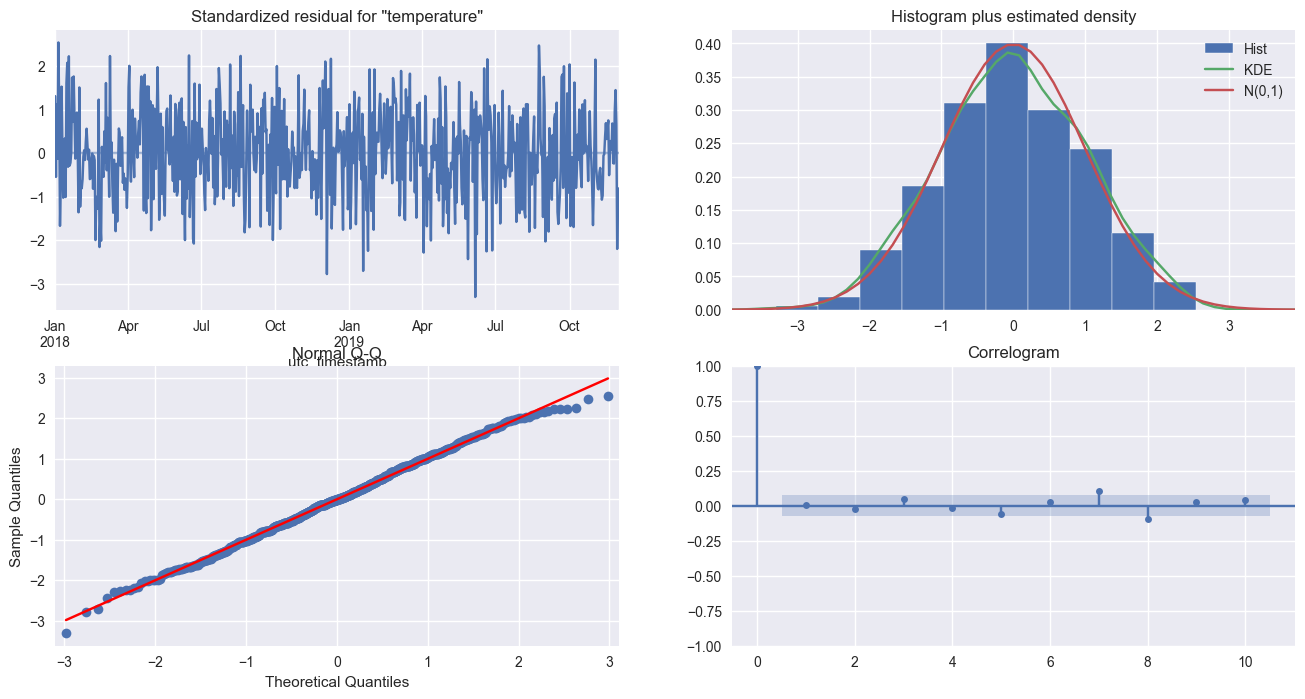

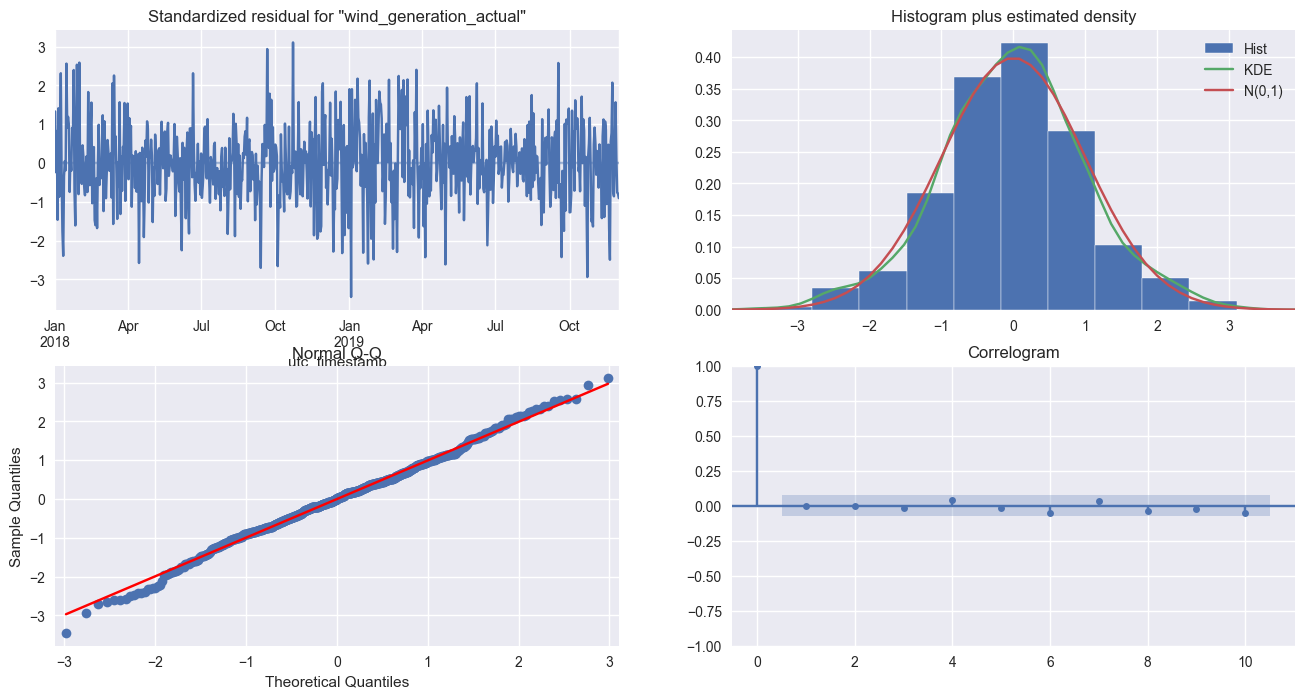

In [140]:
# Plot diagnostic for temperature
VAR_best_model.plot_diagnostics(figsize=(16,8), variable=0);

# Plot diagnostic for wind_generation_actual
VAR_best_model.plot_diagnostics(figsize=(16,8), variable=1);

<h5><b>Prediction</b></h5>

In [142]:
predictions = VAR_best_model.get_prediction(start=data_test_VAR.index[0], end=data_test_VAR.index[-1])
pred_temperature = predictions.predicted_mean['temperature']
pred_wind_generation_actual = predictions.predicted_mean['wind_generation_actual']

In [153]:
from datetime import timedelta

def invert_transformation(df_train):
     forecasting =  pd.DataFrame(columns=['wind_generation_actual']) #data_test
     df_fc = predictions.predicted_mean.wind_generation_actual
     ls = dict()
     for idx in df_fc.index:
          value = df_train[idx - timedelta(365)] + (df_fc[idx])
          ls[idx] = value
     forecasting = pd.DataFrame(ls.items(),columns=['date_time','wind_generation_actual'])
     forecasting.index = forecasting.date_time
     forecasting.drop('date_time', inplace=True, axis=1)
     return forecasting
df_final = invert_transformation(data_train_VAR.wind_generation_actual)


Text(0, 0.5, 'Wind generation actual')

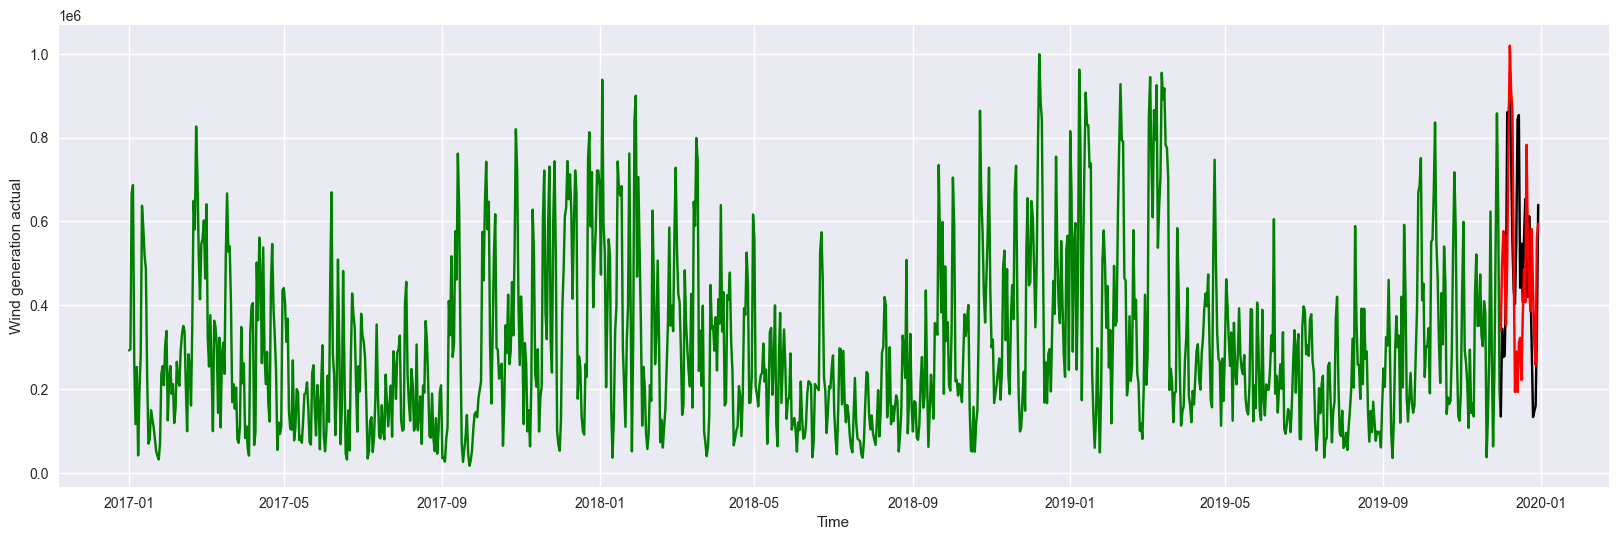

In [154]:
# Visualize the results
plt.figure(figsize=(20,6))
plt.plot(data_train_VAR.wind_generation_actual,'green')
plt.plot(data_test_VAR.wind_generation_actual,'black')
plt.plot(df_final,'-r')
plt.xlabel('Time')
plt.ylabel('Wind generation actual')

<h5><b>Zoom</b></h5>

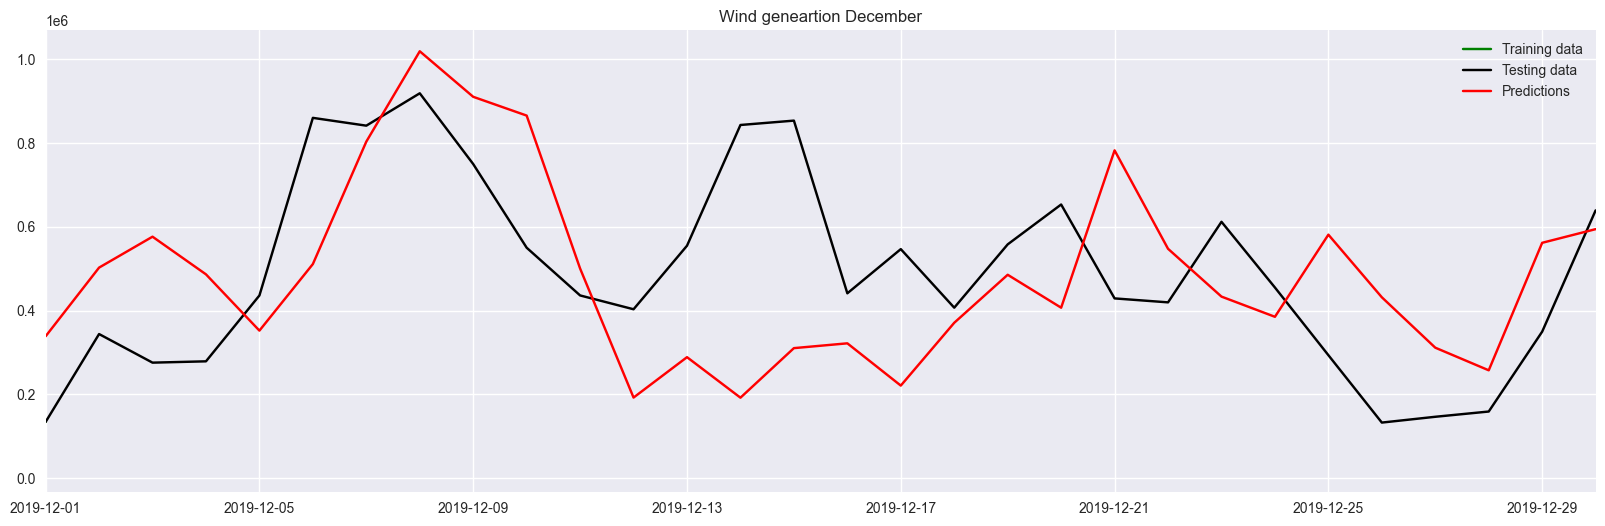

In [155]:
# Plot the data and predictions
fig = plt.figure(figsize=(20,6))
plt.plot(data_train_VAR.wind_generation_actual, color='green', label='Training data')
plt.plot(data_test_VAR.wind_generation_actual, color='black', label='Testing data')
plt.plot(df_final, color='red', label='Predictions')


# Zoom into the prediction part
start_index = df_final.index[-30]  # Start of zoom
end_index = df_final.index[-1]      # End of zoom
plt.xlim(start_index, end_index)
plt.title('Wind geneartion December')
plt.legend()
plt.show()

<h5><b>Metrics</b></h5>

In [198]:
VAR_temp = {
    'Model_name': 'VAR temp', 
    'AIC': VAR_best_model.aic, 
    'BIC': VAR_best_model.bic, 
    'MAE': mean_absolute_error(data_test_VAR.wind_generation_actual, df_final), 
    'MAPE': mean_absolute_percentage_error(data_test_VAR.wind_generation_actual, df_final),
    'RMSE': mean_squared_error(data_test_VAR.wind_generation_actual, df_final, squared=False)
}
VAR_temp

{'Model_name': 'VAR temp',
 'AIC': 22214.726957496925,
 'BIC': 22292.09532319266,
 'MAE': 209711.87905657044,
 'MAPE': 0.5534910657510926,
 'RMSE': 253403.32258607203}

<h3><b>Best Model selection</b></h3>

In [196]:
BEST_MODEL_f = [ets_140, ets_68, ets_weekly, Manual_SARIMA, Auto_SARIMA, Exog_wind_Sarima, Exog_temp_Sarima, Exog_both_Sarima, VAR_temp]
BEST_MODEL_df = pd.DataFrame(BEST_MODEL_f)
BEST_MODEL_df


Model_name           AIC           BIC            MAE      MAPE  \
0     ETS Daily 140  29854.857453  30584.506466  142118.558450  0.319012   
1      ETS Daily 68  29653.552906  30023.375008  147544.286419  0.337493   
2     Manual SARIMA   2432.913651   2445.467948  124055.528778  0.327439   
3       Auto SARIMA   2402.653515   2420.229531  116402.348580  0.300588   
4  Exog wind SARIMA   2403.438729   2421.014746  114050.192606  0.300373   
5  Exog temp SARIMA   2405.033575   2425.120451  114078.528364  0.291168   
6  Exog both SARIMA   2414.513420   2427.067718  115616.522053  0.308749   
7        ETS Weekly   3902.872349   4074.717337   99657.164162  0.274063   
8          VAR temp  22214.726957  22292.095323  209711.879057  0.553491   

            RMSE  
0  180006.909904  
1  185596.879304  
2  139156.172800  
3  131560.952584  
4  129635.458358  
5  131454.635465  
6  129978.870810  
7  112923.023045  
8  253403.322586

<h5><b>Best AIC</b></h5>

In [202]:
#Model with lowest AIC
BEST_MODEL_df[BEST_MODEL_df.AIC == BEST_MODEL_df.AIC.min()]

Model_name          AIC          BIC           MAE      MAPE  \
3  Auto SARIMA  2402.653515  2420.229531  116402.34858  0.300588   

            RMSE  
3  131560.952584

<h5><b>Best BIC</b></h5>

In [204]:
#Model with lowest BIC
BEST_MODEL_df[BEST_MODEL_df.BIC == BEST_MODEL_df.BIC.min()]

Model_name          AIC          BIC           MAE      MAPE  \
3  Auto SARIMA  2402.653515  2420.229531  116402.34858  0.300588   

            RMSE  
3  131560.952584

<h5><b>Best MAE</b></h5>

In [205]:
#Model with lowest MAE
BEST_MODEL_df[BEST_MODEL_df.MAE == BEST_MODEL_df.MAE.min()]

Model_name          AIC          BIC           MAE      MAPE           RMSE
7  ETS Weekly  3902.872349  4074.717337  99657.164162  0.274063  112923.023045

<h5><b>Best MAPE</b></h5>

In [206]:
#Model with lowest MAPE
BEST_MODEL_df[BEST_MODEL_df.MAPE == BEST_MODEL_df.MAPE.min()]

Model_name          AIC          BIC           MAE      MAPE           RMSE
7  ETS Weekly  3902.872349  4074.717337  99657.164162  0.274063  112923.023045

<h5><b>Best RMSE</b></h5>

In [207]:
#Model with lowest RMSE
BEST_MODEL_df[BEST_MODEL_df.RMSE == BEST_MODEL_df.RMSE.min()]

Model_name          AIC          BIC           MAE      MAPE           RMSE
7  ETS Weekly  3902.872349  4074.717337  99657.164162  0.274063  112923.023045

<h3><b>CONCLUSION</b></h3>

Choosing the best model is not so simple because it depends on several factors. 
- One option might be to decide which metrics are most important to your application. For example, you might give more weight to AIC and RMSE.
- Combine multiple metrics, you can create a weighted overall score.
- Don’t just rely on numbers. Also consider the chart trend of predictions and their significance in the context of your specific problem. A model with the best numerical accuracy may not be the best choice if its predictions are not intuitive or easily interpreted.

Another important thing that maybe can address to the best model is the Durbin-Watson test. A value of 1.902 (ets_weekly) is generally preferable to one with a Durbin-Watson of 1.366 (auto_SARIMA), because it indicates greater residuals independence and therefore more reliable statistical estimates and inferences.

One thing I can say, based on the metrics used the two models that could be the best candidates are: Auto SARIMA and ETS Weekly but if we consider the Durbin-Watson test as an extra positive feature, I think the ETS Weekly could be the the best model.

Even if we check every single trend (up or down) in the zoom's weekly plot, the ETS Weekly make less errors.